Using device: cuda

System Information:
CPU Cores: 4 physical, 8 logical
Total RAM: 7.71 GB
GPU: NVIDIA GeForce MX450
CUDA Version: 11.8
GPU Memory: 2.00 GB

Loading full dataset...
Class 01substring open circuit: 595 images
Class 02short circuit panel: 427 images
Class 03string short circuit: 71 images
Class 04debris cover: 410 images
Class 05shadow: 303 images
Class 06bottom dirt: 377 images
Class 07panel break: 131 images
Class 08junction box overheating: 800 images
Class 09hot cell: 946 images
Class 10healthy panel: 1519 images
Class 01substring open circuit: 595 images
Class 02short circuit panel: 427 images
Class 03string short circuit: 71 images
Class 04debris cover: 410 images
Class 05shadow: 303 images
Class 06bottom dirt: 377 images
Class 07panel break: 131 images
Class 08junction box overheating: 800 images
Class 09hot cell: 946 images
Class 10healthy panel: 1519 images
Class 01substring open circuit: 595 images
Class 02short circuit panel: 427 images
Class 03string short ci

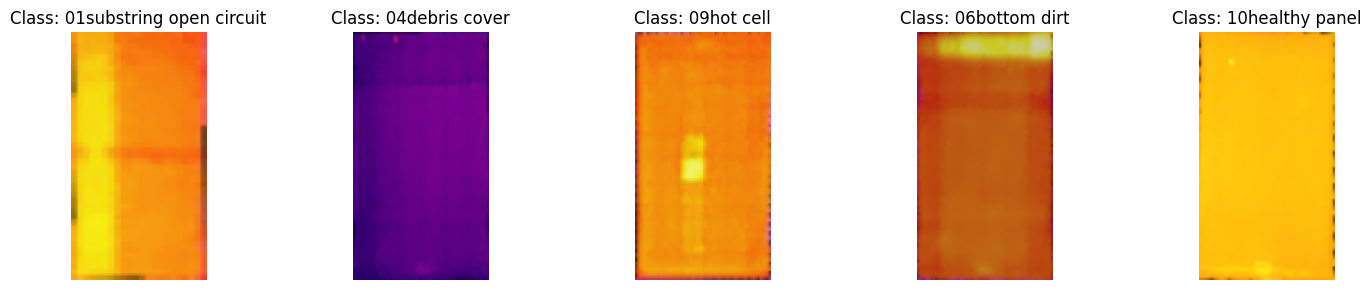


Visualizing class distribution across datasets:


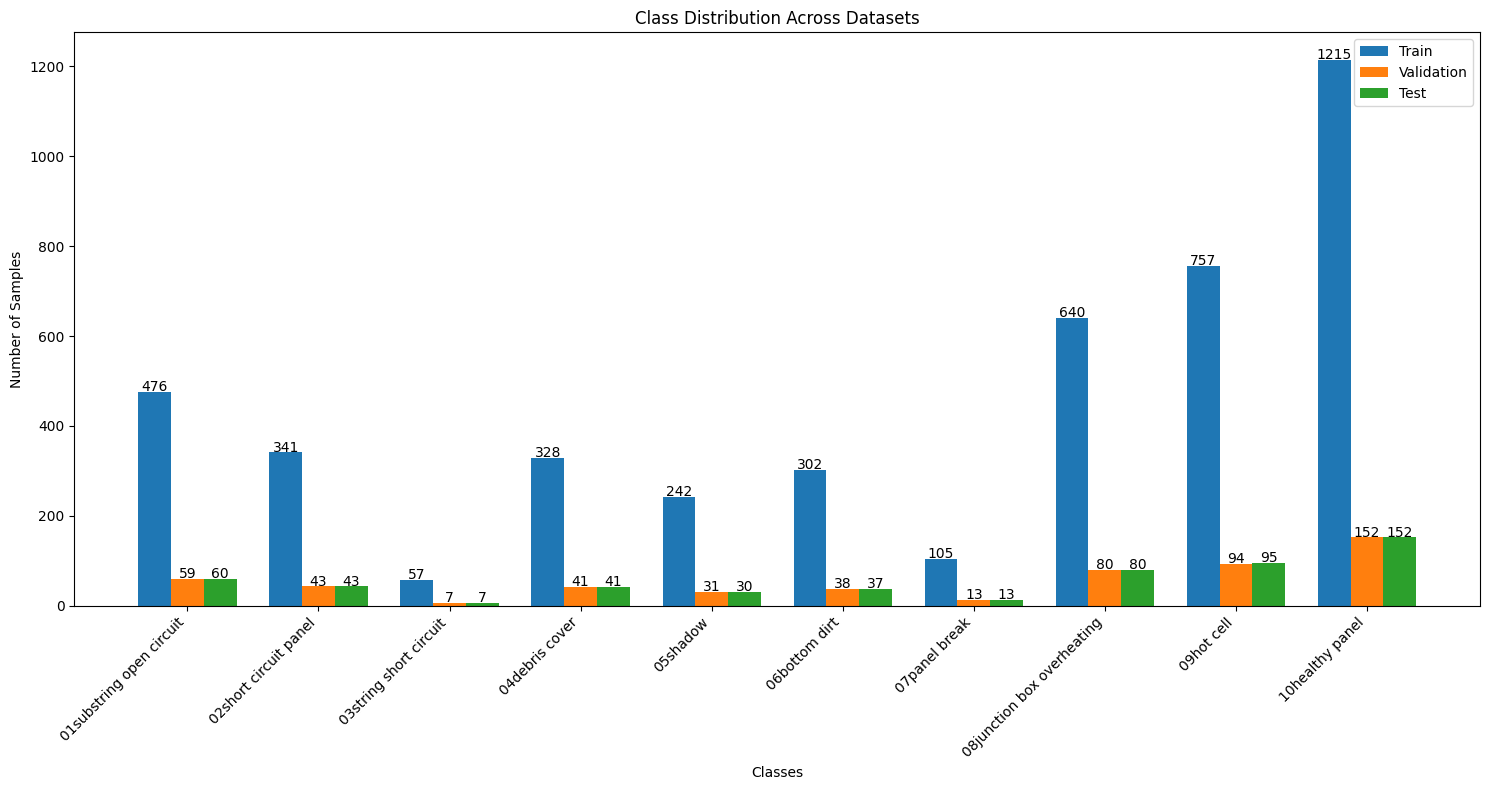


Starting model training with comprehensive performance tracking...

Training with AdamW optimizer, ENS weighting, and cosine scheduler

Model Summary
EfficientNetB0: Training approximately last 4 of 8 feature blocks and classifier (approx. 50.0% unfreezing)


C:\Users\tanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

KeyboardInterrupt: 

In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import time
from datetime import datetime
from PIL import ImageOps
import torch.nn.functional as F
import psutil
import pandas as pd
import gc
from pynvml import *
from torchsummary import summary
from sklearn.model_selection import train_test_split
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
import random

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ----------------------------
# Benchmarking Utilities
# ----------------------------

def calculate_flops(model, input_size=(1, 3, 224, 224)):
    """Calculate FLOPs for the model with better operator support"""
    from fvcore.nn import FlopCountAnalysis, flop_count_table
    
    model.eval()
    device = next(model.parameters()).device
    inputs = torch.randn(input_size).to(device)
    
    # Calculate FLOPs
    flops = FlopCountAnalysis(model, inputs)
    
    # Print detailed table (optional)
    print("\nFLOPs Breakdown:")
    print(flop_count_table(flops))
    
    return flops.total()

def benchmark_model(model, test_loader, device, num_runs=100):
    """Enhanced benchmarking with more metrics"""
    model.eval()
    times = []
    flops = None
    
    try:
        # Calculate FLOPs first
        flops = calculate_flops(model)
    except Exception as e:
        print(f"\nFLOPs calculation warning: {str(e)}")
        flops = None
    
    # Create dummy input with same shape as actual data
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    
    with torch.no_grad():
        # Warmup
        for _ in range(10):
            _ = model(dummy_input)
        
        # Benchmark
        for _ in range(num_runs):
            start = time.time()
            _ = model(dummy_input)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            times.append(time.time() - start)
    
    # Memory usage
    if device.type == 'cuda':
        torch.cuda.synchronize()
        mem_stats = {
            'allocated_mb': torch.cuda.memory_allocated(device) / 1024**2,
            'reserved_mb': torch.cuda.memory_reserved(device) / 1024**2,
            'max_allocated_mb': torch.cuda.max_memory_allocated(device) / 1024**2
        }
    else:
        process = psutil.Process()
        mem_info = process.memory_info()
        mem_stats = {
            'rss_mb': mem_info.rss / 1024**2,
            'vms_mb': mem_info.vms / 1024**2
        }
    
    return {
        'avg_inference_time': np.mean(times),
        'fps': 1/np.mean(times),
        'std_dev': np.std(times),
        'flops': flops,
        'flops_g': flops / 1e9 if flops else None,
        **mem_stats
    }

def get_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

def count_parameters(model):
    """Count total number of trainable parameters in millions"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6

def get_memory_usage(device):
    """Get current memory usage in MB"""
    if device.type == 'cuda':
        torch.cuda.synchronize()
        return {
            'allocated_memory_mb': torch.cuda.memory_allocated(device) / 1024**2,
            'reserved_memory_mb': torch.cuda.memory_reserved(device) / 1024**2
        }
    else:
        process = psutil.Process()
        return {'ram_usage_mb': process.memory_info().rss / 1024**2}

def get_detailed_memory_usage(device):
    """Get detailed memory usage statistics"""
    if device.type == 'cuda':
        torch.cuda.synchronize()
        return {
            'allocated_memory_mb': torch.cuda.memory_allocated(device) / 1024**2,
            'reserved_memory_mb': torch.cuda.memory_reserved(device) / 1024**2,
            'max_allocated_mb': torch.cuda.max_memory_allocated(device) / 1024**2,
            'max_reserved_mb': torch.cuda.max_memory_reserved(device) / 1024**2
        }
    else:
        process = psutil.Process()
        mem_info = process.memory_info()
        return {
            'ram_usage_mb': mem_info.rss / 1024**2,
            'virtual_memory_mb': mem_info.vms / 1024**2
        }

# ----------------------------
# Performance Logger Class
# ----------------------------

class PerformanceLogger:
    def __init__(self, experiment_name="PV_Fault_Detection"):
        self.experiment_name = experiment_name
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Create the base directory if it doesn't exist
        base_log_dir = "C:/Users/tanan/Downloads/anchee_fyp2/performance_logs"
        os.makedirs(base_log_dir, exist_ok=True)
        
        # Create the experiment-specific directory
        self.log_dir = os.path.join(base_log_dir, f"{experiment_name}_{self.timestamp}")
        os.makedirs(self.log_dir, exist_ok=True)
        
        # Initialize data structures
        self.epoch_metrics = []
        self.system_metrics = []
        self.final_metrics = {}
        self.confusion_matrix = None
        self.classification_report = None
        
    def log_epoch(self, epoch, train_loss, train_acc, val_loss, val_acc, lr):
        """Log metrics for each epoch"""
        epoch_data = {
            'epoch': epoch + 1,
            'train_loss': float(train_loss),
            'train_accuracy': float(train_acc),
            'val_loss': float(val_loss),
            'val_accuracy': float(val_acc),
            'learning_rate': float(lr),
            'timestamp': datetime.now().isoformat()
        }
        self.epoch_metrics.append(epoch_data)
        
    def log_system(self, cpu, ram, gpu=None, gpu_mem=None):
        """Log system metrics"""
        sys_data = {
            'timestamp': datetime.now().isoformat(),
            'cpu_usage': float(cpu),
            'ram_usage': float(ram),
            'gpu_usage': float(gpu) if gpu is not None else None,
            'gpu_memory': float(gpu_mem) if gpu_mem is not None else None
        }
        self.system_metrics.append(sys_data)
        
    def log_final_metrics(self, metrics_dict):
        """Log final metrics"""
        self.final_metrics = metrics_dict
        
    def log_classification_report(self, report_dict):
        """Log classification report"""
        self.classification_report = report_dict
        
    def log_confusion_matrix(self, cm, class_names):
        """Log confusion matrix"""
        self.confusion_matrix = {
            'matrix': cm.tolist(),
            'class_names': class_names
        }
    
    def save_all(self):
        """Save all logged data to files"""
        try:
            # Ensure directory exists
            os.makedirs(self.log_dir, exist_ok=True)
            
            # Save epoch metrics
            epoch_path = os.path.join(self.log_dir, "epoch_metrics.json")
            with open(epoch_path, 'w') as f:
                json.dump(self.epoch_metrics, f, indent=4)
                
            # Save system metrics
            system_path = os.path.join(self.log_dir, "system_metrics.json")
            with open(system_path, 'w') as f:
                json.dump(self.system_metrics, f, indent=4)
                
            # Save final metrics
            final_path = os.path.join(self.log_dir, "final_metrics.json")
            with open(final_path, 'w') as f:
                json.dump(self.final_metrics, f, indent=4)
                
            # Save classification report
            if self.classification_report:
                report_json_path = os.path.join(self.log_dir, "classification_report.json")
                with open(report_json_path, 'w') as f:
                    json.dump(self.classification_report, f, indent=4)
                
                report_txt_path = os.path.join(self.log_dir, "classification_report.txt")
                with open(report_txt_path, 'w') as f:
                    f.write(classification_report_to_text(self.classification_report))
                    
            # Save confusion matrix
            if self.confusion_matrix:
                cm_path = os.path.join(self.log_dir, "confusion_matrix.json")
                with open(cm_path, 'w') as f:
                    json.dump(self.confusion_matrix, f, indent=4)
                
                # Save confusion matrix plot
                plt.figure(figsize=(12, 10))
                sns.heatmap(self.confusion_matrix['matrix'], annot=True, fmt='d', cmap='Blues',
                            xticklabels=self.confusion_matrix['class_names'],
                            yticklabels=self.confusion_matrix['class_names'])
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.title('Confusion Matrix')
                plt.tight_layout()
                cm_plot_path = os.path.join(self.log_dir, "confusion_matrix.png")
                plt.savefig(cm_plot_path)
                plt.close()
                
            # Save training curves
            if len(self.epoch_metrics) > 0:
                self._save_training_curves()
                
            print(f"\nAll performance metrics saved to: {self.log_dir}")
            
        except Exception as e:
            print(f"\nError saving performance metrics: {str(e)}")
        
    def _save_training_curves(self):
        """Save training and validation curves"""
        epochs = [m['epoch'] for m in self.epoch_metrics]
        train_loss = [m['train_loss'] for m in self.epoch_metrics]
        val_loss = [m['val_loss'] for m in self.epoch_metrics]
        train_acc = [m['train_accuracy'] for m in self.epoch_metrics]
        val_acc = [m['val_accuracy'] for m in self.epoch_metrics]
        
        # Loss curve
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, train_loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{self.log_dir}/loss_curve.png")
        plt.close()
        
        # Accuracy curve
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, train_acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{self.log_dir}/accuracy_curve.png")
        plt.close()
        
        # Combined curve
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        ax1.plot(epochs, train_loss, label='Training Loss')
        ax1.plot(epochs, val_loss, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(epochs, train_acc, label='Training Accuracy')
        ax2.plot(epochs, val_acc, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(f"{self.log_dir}/training_curves.png")
        plt.close()

def classification_report_to_text(report_dict):
    """Convert classification report dictionary to text format"""
    text = "\nClassification Report:\n"
    text += f"{'':<15}{'precision':>10}{'recall':>10}{'f1-score':>10}{'support':>10}\n"
    
    # Add metrics for each class
    for class_name in report_dict:
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        metrics = report_dict[class_name]
        text += f"{class_name:<15}{metrics['precision']:>10.2f}{metrics['recall']:>10.2f}{metrics['f1-score']:>10.2f}{metrics['support']:>10}\n"
    
    # Add overall accuracy
    if 'accuracy' in report_dict:
        text += f"\n{'accuracy':<15}{'':30}{report_dict['accuracy']:>10.2f}\n"
    
    # Add macro and weighted averages
    for avg_type in ['macro avg', 'weighted avg']:
        if avg_type in report_dict:
            metrics = report_dict[avg_type]
            text += f"{avg_type:<15}{metrics['precision']:>10.2f}{metrics['recall']:>10.2f}{metrics['f1-score']:>10.2f}{metrics['support']:>10}\n"
    
    return text

# ----------------------------
# System Monitoring Class
# ----------------------------

class SystemMonitor:
    def __init__(self):
        self.cpu_usages = []
        self.ram_usages = []
        self.gpu_usages = []
        self.gpu_memories = []
        self.timestamps = []
        self.gpu_available = False
        
        # Initialize GPU monitoring if available
        try:
            nvmlInit()
            self.gpu_available = True
            self.gpu_handles = [nvmlDeviceGetHandleByIndex(i) for i in range(nvmlDeviceGetCount())]
        except:
            self.gpu_available = False
        
    def record(self):
        """Record current system metrics"""
        # Record timestamp
        self.timestamps.append(time.time())
        
        # CPU and RAM usage
        self.cpu_usages.append(psutil.cpu_percent())
        self.ram_usages.append(psutil.virtual_memory().percent)
        
        # GPU usage if available
        if self.gpu_available:
            try:
                gpu_usage = nvmlDeviceGetUtilizationRates(self.gpu_handles[0]).gpu
                gpu_mem = nvmlDeviceGetMemoryInfo(self.gpu_handles[0]).used / nvmlDeviceGetMemoryInfo(self.gpu_handles[0]).total * 100
                self.gpu_usages.append(gpu_usage)
                self.gpu_memories.append(gpu_mem)
            except:
                self.gpu_usages.append(0)
                self.gpu_memories.append(0)
        else:
            self.gpu_usages.append(0)
            self.gpu_memories.append(0)
    
    def get_summary(self):
        """Get summary statistics of system metrics"""
        summary = {
            'cpu': {
                'mean': float(np.mean(self.cpu_usages)),
                'max': float(np.max(self.cpu_usages)),
                'min': float(np.min(self.cpu_usages)),
                'std': float(np.std(self.cpu_usages))
            },
            'ram': {
                'mean': float(np.mean(self.ram_usages)),
                'max': float(np.max(self.ram_usages)),
                'min': float(np.min(self.ram_usages)),
                'std': float(np.std(self.ram_usages))
            }
        }
        
        if any(usage > 0 for usage in self.gpu_usages):
            summary['gpu'] = {
                'usage_mean': float(np.mean(self.gpu_usages)),
                'usage_max': float(np.max(self.gpu_usages)),
                'usage_min': float(np.min(self.gpu_usages)),
                'usage_std': float(np.std(self.gpu_usages)),
                'memory_mean': float(np.mean(self.gpu_memories)),
                'memory_max': float(np.max(self.gpu_memories)),
                'memory_min': float(np.min(self.gpu_memories)),
                'memory_std': float(np.std(self.gpu_memories))
            }
        
        return summary
    
    def save_metrics_plot(self, save_path):
        """Save system metrics visualization"""
        plt.figure(figsize=(15, 10))
        
        # Calculate relative timestamps
        if len(self.timestamps) > 0:
            relative_times = [t - self.timestamps[0] for t in self.timestamps]
        else:
            relative_times = []
        
        # CPU Usage
        plt.subplot(2, 2, 1)
        plt.plot(relative_times, self.cpu_usages, label='CPU Usage')
        plt.title('CPU Usage During Training')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        
        # RAM Usage
        plt.subplot(2, 2, 2)
        plt.plot(relative_times, self.ram_usages, label='RAM Usage')
        plt.title('RAM Usage During Training')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        
        # GPU Usage (if available)
        if any(usage > 0 for usage in self.gpu_usages):
            plt.subplot(2, 2, 3)
            plt.plot(relative_times, self.gpu_usages, label='GPU Usage')
            plt.title('GPU Usage During Training')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Percentage (%)')
            plt.ylim(0, 100)
            plt.grid(True)
            
            plt.subplot(2, 2, 4)
            plt.plot(relative_times, self.gpu_memories, label='GPU Memory')
            plt.title('GPU Memory Usage During Training')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Percentage (%)')
            plt.ylim(0, 100)
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

# ----------------------------
# Data Preparation Functions
# ----------------------------

def preparing_data():
    """Prepare and load the dataset with correct train/validation/test split (80/10/10)"""
    # Define data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val_test': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Set the full data directory
    data_dir = "C:/Users/tanan/Downloads/anchee_fyp2/PVF_10/PVF_10_Processed"

    # Create dataset from the full directory with no transform
    print("\nLoading full dataset...")
    full_dataset = PVFaultDataset(data_dir, transform=None)

    # First split into train and temp (80/20)
    train_indices, temp_indices = train_test_split(
        list(range(len(full_dataset))), 
        test_size=0.2,
        stratify=[full_dataset.labels[i] for i in range(len(full_dataset))],
        random_state=42
    )
    
    # Further split temp into validation and test (10/10 of the original dataset)
    val_indices, test_indices = train_test_split(
        temp_indices,
        test_size=0.5,
        stratify=[full_dataset.labels[i] for i in temp_indices],
        random_state=42
    )

    # Create datasets with transforms
    train_dataset = PVFaultDataset(data_dir, transform=data_transforms['train'])
    train_dataset.img_paths = [full_dataset.img_paths[i] for i in train_indices]
    train_dataset.labels = [full_dataset.labels[i] for i in train_indices]

    val_dataset = PVFaultDataset(data_dir, transform=data_transforms['val_test'])
    val_dataset.img_paths = [full_dataset.img_paths[i] for i in val_indices]
    val_dataset.labels = [full_dataset.labels[i] for i in val_indices]

    test_dataset = PVFaultDataset(data_dir, transform=data_transforms['val_test'])
    test_dataset.img_paths = [full_dataset.img_paths[i] for i in test_indices]
    test_dataset.labels = [full_dataset.labels[i] for i in test_indices]

    # Print dataset sizes
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, drop_last=False)

    # Get class information
    class_names = full_dataset.classes
    num_classes = len(class_names)
    print(f"\nNumber of classes: {num_classes}")
    print(f"Class names: {class_names}")

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, class_names, num_classes

# Dataset class
class PVFaultDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.img_paths = []
        self.labels = []
        
        # Load all image paths and their labels
        for class_name in self.classes:
            class_dir = os.path.join(img_dir, class_name)
            class_count = 0
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png', '.tif')):
                    self.img_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])
                    class_count += 1
            print(f"Class {class_name}: {class_count} images")
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply transform here consistently
        if self.transform:
            image = self.transform(image)
        else:
            # Ensure tensor conversion even without transform
            image = transforms.ToTensor()(image)
            
        return image, label

# ----------------------------
# Visualization Functions
# ----------------------------

def visualize_samples(dataset, num_samples=5):
    """Visualize sample images from the dataset"""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    # Get class names from the original dataset if it's a TransformDataset
    if hasattr(dataset, 'subset') and hasattr(dataset.subset.dataset, 'classes'):
        classes = dataset.subset.dataset.classes
    elif hasattr(dataset, 'classes'):
        classes = dataset.classes
    else:
        # Fallback if classes can't be found
        classes = [f"Class {i}" for i in range(10)]  # Generic class names
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {classes[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_results(train_losses, train_accuracies, val_losses, val_accuracies, all_preds, all_labels, class_names):
    """Visualize training results and metrics"""
    # Figure 1: Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Figure 2: Training and Validation Accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Figure 3: Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

def visualize_computational_metrics(monitor, total_time, train_size, test_size):
    """Visualize computational efficiency metrics"""
    plt.figure(figsize=(15, 10))
    
    # Calculate relative timestamps
    if len(monitor.timestamps) > 0:
        relative_times = [t - monitor.timestamps[0] for t in monitor.timestamps]
    else:
        relative_times = []
    
    # CPU Usage
    plt.subplot(2, 2, 1)
    plt.plot(relative_times, monitor.cpu_usages, label='CPU Usage')
    plt.title('CPU Usage During Training')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(True)
    
    # RAM Usage
    plt.subplot(2, 2, 2)
    plt.plot(relative_times, monitor.ram_usages, label='RAM Usage')
    plt.title('RAM Usage During Training')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(True)
    
    # GPU Usage (if available)
    if any(usage > 0 for usage in monitor.gpu_usages):
        plt.subplot(2, 2, 3)
        plt.plot(relative_times, monitor.gpu_usages, label='GPU Usage')
        plt.title('GPU Usage During Training')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        
        plt.subplot(2, 2, 4)
        plt.plot(relative_times, monitor.gpu_memories, label='GPU Memory')
        plt.title('GPU Memory Usage During Training')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nComputational Efficiency Metrics:")
    print(f"Total Training Time: {total_time:.2f} seconds")
    print(f"Training Set Size: {train_size} samples")
    print(f"Test Set Size: {test_size} samples")
    print(f"Average CPU Usage: {np.mean(monitor.cpu_usages):.2f}%")
    print(f"Average RAM Usage: {np.mean(monitor.ram_usages):.2f}%")
    
    if any(usage > 0 for usage in monitor.gpu_usages):
        print(f"Average GPU Usage: {np.mean(monitor.gpu_usages):.2f}%")
        print(f"Average GPU Memory Usage: {np.mean(monitor.gpu_memories):.2f}%")

def visualize_class_distribution(train_dataset, val_dataset, test_dataset, class_names):
    """Visualize class distribution across train, val, and test sets in a single bar chart"""
    # Get counts for each dataset
    train_counts = np.zeros(len(class_names))
    val_counts = np.zeros(len(class_names))
    test_counts = np.zeros(len(class_names))
    
    # Count samples in train set
    for _, label in train_dataset:
        train_counts[label] += 1
    
    # Count samples in validation set
    for _, label in val_dataset:
        val_counts[label] += 1
    
    # Count samples in test set
    for _, label in test_dataset:
        test_counts[label] += 1
    
    # Create figure
    plt.figure(figsize=(15, 8))
    bar_width = 0.25
    index = np.arange(len(class_names))
    
    # Plot bars for each dataset
    plt.bar(index, train_counts, bar_width, label='Train')
    plt.bar(index + bar_width, val_counts, bar_width, label='Validation')
    plt.bar(index + 2*bar_width, test_counts, bar_width, label='Test')
    
    # Customize plot
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution Across Datasets')
    plt.xticks(index + bar_width, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # Add exact numbers on top of bars
    for i in range(len(class_names)):
        plt.text(i, train_counts[i] + 2, str(int(train_counts[i])), ha='center')
        plt.text(i + bar_width, val_counts[i] + 2, str(int(val_counts[i])), ha='center')
        plt.text(i + 2*bar_width, test_counts[i] + 2, str(int(test_counts[i])), ha='center')
    
    plt.show()

# ----------------------------
# Model Functions
# ----------------------------

def create_efficientnetb0_model(num_classes, unfreeze_percentage=0.50):
    """
    Create EfficientNetB0 with a configurable unfreeze percentage and an enhanced classifier head.

    Args:
        num_classes (int): The number of output classes for the classifier.
        unfreeze_percentage (float): The approximate percentage of the backbone to unfreeze
                                     from the end (e.g., 0.25 for last 25%, 0.5 for last 50%).
                                     Set to 1.0 to unfreeze all layers.
    Returns:
        torch.nn.Module: The configured EfficientNetB0 model.
    """
    model = models.efficientnet_b0(pretrained=True)
    
    # EfficientNetB0 has 8 blocks in its features (0-7)
    total_feature_blocks = 8
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Determine which blocks to unfreeze based on the percentage
    num_unfreeze_blocks = int(total_feature_blocks * unfreeze_percentage)
    if num_unfreeze_blocks == 0 and unfreeze_percentage > 0: # Ensure at least one block if percentage > 0
        num_unfreeze_blocks = 1 
    
    start_unfreeze_block_idx = total_feature_blocks - num_unfreeze_blocks
    
    # Unfreeze specific blocks and the classifier
    for name, param in model.named_parameters():
        # Unfreeze blocks from 'start_unfreeze_block_idx' to 'total_feature_blocks - 1'
        if any(f"features.{i}" in name for i in range(start_unfreeze_block_idx, total_feature_blocks)) or "classifier" in name:
            param.requires_grad = True
            
    print(f"EfficientNetB0: Training approximately last {num_unfreeze_blocks} of {total_feature_blocks} feature blocks and classifier (approx. {100*num_unfreeze_blocks/total_feature_blocks:.1f}% unfreezing)")
    
    # Enhanced classifier head (matching your ResNet/MobileNetV2 implementation)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    
    return model

def report_model_params(model, model_name="EfficientNetB0"):
    """Analyzes and reports model's trainable vs total parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    
    print(f"\n{model_name} Parameter Analysis:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
    print(f"Frozen parameters: {frozen_params:,} ({frozen_params/total_params:.2%})")
    
    return {
        "model": model_name,
        "total_params": total_params,
        "trainable_params": trainable_params,
        "frozen_params": frozen_params,
        "trainable_percentage": trainable_params/total_params
    }

def initialize_model(num_classes, device):
    """Initialize the model and move it to the specified device"""
    model_name = EfficientNetB0
    print(f"\nInitializing {model_name}...")
    
    model = create_efficientnetb0_model(num_classes, unfreeze_percentage=0.50)
    
    # Report parameter statistics
    param_stats = report_model_params(model, model_name)
    
    model = model.to(device)
    return model, param_stats

# ----------------------------
# Training Utilities
# ----------------------------

def get_class_weights(dataset, num_classes, method='ens', beta=0.95):
    """
    Calculate class weights using different methods
    
    Args:
        dataset: Training dataset
        num_classes: Number of classes
        method: Weighting method ('ins', 'isns', 'ens', 'equal')
        beta: Beta parameter for ENS method
    
    Returns:
        weights_tensor: Tensor of class weights
        raw_weights: Raw weights before normalization
        balanced_weights: Final normalized weights
    """
    # Get class counts
    class_counts = np.zeros(num_classes)
    for _, label in dataset:
        class_counts[label] += 1

    samples_per_class = class_counts.astype(int)
    
    # Check for empty classes
    if np.any(samples_per_class == 0):
        print(f"Warning: Found classes with 0 samples: {np.where(samples_per_class == 0)[0]}")
        # Handle empty classes by setting minimum count to 1
        samples_per_class = np.maximum(samples_per_class, 1)

    # Calculate method-specific raw weights
    if method == 'ins':
        # Inverse Number of Samples: weight_c = 1 / n_c
        raw_weights = 1.0 / samples_per_class
        
    elif method == 'isns':
        # Inverse Square Root Number of Samples: weight_c = 1 / sqrt(n_c)
        raw_weights = 1.0 / np.sqrt(samples_per_class)
        
    elif method == 'ens':
        # Effective Number of Samples: weight_c = 1 / effective_num
        effective_num = (1.0 - np.power(beta, samples_per_class)) / (1.0 - beta)
        raw_weights = 1.0 / effective_num
        
    elif method == 'equal':
        # Equal weights (no reweighting)
        raw_weights = np.ones(num_classes)
        
    else:
        raise ValueError(f"Unknown method: {method}. Available: ['ins', 'isns', 'ens', 'equal']")

    # Normalize weights to sum to num_classes (standard practice)
    balanced_weights = raw_weights / np.sum(raw_weights) * num_classes
    
    # Convert to tensor
    weights_tensor = torch.tensor(balanced_weights, dtype=torch.float32)

    print(f"\nClass Weighting Method: {method.upper()}")
    print(f"Class counts: {samples_per_class}")
    print(f"Raw weights: {raw_weights}")
    print(f"Balanced weights: {balanced_weights}")
    print(f"Sum of balanced weights: {np.sum(balanced_weights):.4f}")

    return weights_tensor, raw_weights, balanced_weights

def visualize_class_weights(class_names, class_counts, raw_weights, final_weights, logger=None, method='ens'):
    """Plot the complete transformation chain clearly"""
    plt.figure(figsize=(20, 6))

    # Step 1: Original distribution (normalized to probabilities)
    original_probs = class_counts / np.sum(class_counts)
    
    # Step 2: Raw weights (method-specific, not normalized)
    # Step 3: Final weights (normalized)
    final_probs = final_weights / np.sum(final_weights)

    print(f"\nComplete Transformation Chain ({method.upper()} method):")
    print(f"{'Class':<15}{'Original Count':>15}{'Original Prob':>15}{'Raw Weight':>15}{'Final Weight':>15}{'Final Prob':>15}")
    print("-" * 90)
    for i, name in enumerate(class_names):
        print(f"{name:<15}{class_counts[i]:>15.0f}{original_probs[i]:>15.4f}{raw_weights[i]:>15.4f}{final_weights[i]:>15.4f}{final_probs[i]:>15.4f}")

    # Create 4 subplots to show the complete transformation
    plt.subplot(1, 4, 1)
    plt.bar(class_names, class_counts)
    plt.title('Step 1: Original Counts')
    plt.xticks(rotation=45)
    plt.ylabel('Count')

    plt.subplot(1, 4, 2)
    plt.bar(class_names, original_probs)
    plt.title('Step 1: Original Probabilities')
    plt.xticks(rotation=45)
    plt.ylabel('Probability')

    plt.subplot(1, 4, 3)
    plt.bar(class_names, raw_weights)
    plt.title(f'Step 2: Raw Weights ({method.upper()})')
    plt.xticks(rotation=45)
    plt.ylabel('Raw Weight')

    plt.subplot(1, 4, 4)
    plt.bar(class_names, final_weights)
    plt.title(f'Step 3: Final Balanced Weights')
    plt.xticks(rotation=45)
    plt.ylabel('Final Weight')

    plt.tight_layout()

    if logger:
        plt.savefig(os.path.join(logger.log_dir, f"class_weights_transformation_{method}.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

    return {
        'class_names': class_names,
        'original_counts': class_counts,
        'original_probs': original_probs,
        'raw_weights': raw_weights,
        'final_weights': final_weights,
        'final_probs': final_probs
    }

def setup_optimizer_scheduler(model, optimizer_type='AdamW', scheduler_type='cosine', class_weights=None, device='cuda', max_epochs=20, logger=None):
    """Enhanced setup with default hyperparameters"""
    """
    Setup optimizer and loss function with class weights
    
    Args:
        model: Neural network model
        optimizer_type: Type of optimizer ('Adam', 'SGD', 'AdamW', etc.)
        class_weights: Tensor of class weights for loss function
        device: Device to move weights to
    
    Returns:
        optimizer: Configured optimizer
        criterion: Loss function with or without class weights
    """
    # Optimizer setup with default hyperparameters
    optimizers = {
        'Adam': optim.Adam(
            model.parameters(), 
            lr=0.001, 
            betas=(0.9, 0.999), 
            eps=1e-08, 
            weight_decay=0, 
            amsgrad=False
        ),
        'SGD': optim.SGD(
            model.parameters(), 
            lr=0.01,
            momentum=0, 
            dampening=0, 
            weight_decay=0, 
            nesterov=False
        ),
        'AdamW': optim.AdamW(
            model.parameters(), 
            lr=0.0005, # Instead of 0.001
            betas=(0.9, 0.999), 
            eps=1e-08, 
            weight_decay=0.1 
        ),
        'RMSprop': optim.RMSprop(
            model.parameters(), 
            lr=0.01, 
            alpha=0.99, 
            eps=1e-08, 
            weight_decay=0, 
            momentum=0, 
            centered=False
        ),
        'Adagrad': optim.Adagrad(
            model.parameters(), 
            lr=0.01,
            lr_decay=0, 
            weight_decay=0, 
            initial_accumulator_value=0, 
            eps=1e-10
        ),
        'Nadam': optim.NAdam(
            model.parameters(), 
            lr=0.002,
            betas=(0.9, 0.999), 
            eps=1e-08, 
            weight_decay=0, 
            momentum_decay=0.004
        ),
    }

    if optimizer_type not in optimizers:
        raise ValueError(f"Unknown optimizer: {optimizer_type}. Available: {list(optimizers.keys())}")

    optimizer = optimizers[optimizer_type]

    # Get initial learning rate for scheduler setup
    initial_lr = optimizer.param_groups[0]['lr']
    
    # Learning rate scheduler setup
    schedulers = {
        'step': StepLR(
            optimizer, 
            step_size=10,  # Decay every 10 epochs
            gamma=0.5      # Multiply LR by 0.5
        ),
        'exponential': ExponentialLR(
            optimizer, 
            gamma=0.95  # Multiply LR by 0.95 each epoch (decay_rate = -ln(0.95) ≈ 0.05)
        ),
        'cosine': CosineAnnealingLR(
            optimizer, 
            T_max=max_epochs,  # Period of cosine annealing
            eta_min=initial_lr * 0.001  # Minimum LR (1% of initial)
        ),
        'none': None  # No scheduler
    }
    
    if scheduler_type not in schedulers:
        raise ValueError(f"Unknown scheduler: {scheduler_type}. Available: {list(schedulers.keys())}")
    
    scheduler = schedulers[scheduler_type]

    # Generate learning rate schedule for visualization
    lr_schedule_data = visualize_lr_schedule(
        scheduler_type, initial_lr, max_epochs, logger
    )
    
    # Add label smoothing to reduce overconfidence
    criterion = nn.CrossEntropyLoss(
        weight=class_weights.to(device) if class_weights is not None else None,
        label_smoothing=0.1  # Add this
    )

    print(f"Optimizer: {optimizer_type}")
    print(f"Scheduler: {scheduler_type}")
    print(f"Initial Learning Rate: {initial_lr}")
    if class_weights is not None:
        print(f"Final weights in loss function: {criterion.weight}")
        print(f"All weights equal to 1.0? {torch.allclose(criterion.weight, torch.ones_like(criterion.weight))}")
        print(f"Exact weight values: {criterion.weight.tolist()}")

    return optimizer, scheduler, criterion, lr_schedule_data

def visualize_lr_schedule(scheduler_type, initial_lr, max_epochs, logger=None):
    """Generate and visualize learning rate schedule"""
    
    if scheduler_type == 'step':
        # Step decay parameters
        decay_factor = 0.5
        step_size = 10
        lr_schedule = [
            initial_lr * (decay_factor ** np.floor((1 + epoch) / step_size)) 
            for epoch in range(max_epochs)
        ]
        title = 'Step Decay Learning Rate Scheduler'
        
    elif scheduler_type == 'exponential':
        # Exponential decay parameters
        decay_rate = 0.05
        lr_schedule = [
            initial_lr * np.exp(-decay_rate * epoch) 
            for epoch in range(max_epochs)
        ]
        title = 'Exponential Decay Learning Rate Scheduler'
        
    elif scheduler_type == 'cosine':
        # Cosine annealing parameters
        lr_min = initial_lr * 0.01  # 1% of initial LR
        lr_max = initial_lr
        lr_schedule = [
            lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(epoch / max_epochs * np.pi)) 
            for epoch in range(max_epochs)
        ]
        title = 'Cosine Annealing Learning Rate Scheduler'
        
    elif scheduler_type == 'none':
        # Constant learning rate
        lr_schedule = [initial_lr] * max_epochs
        title = 'Constant Learning Rate (No Scheduler)'
        
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")
    
    # Create visualization
    plt.figure(figsize=(10, 7))
    plt.plot(lr_schedule, linewidth=2)
    plt.title(title)
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max_epochs-1)
    
    # Add some statistics to the plot
    min_lr = min(lr_schedule)
    max_lr = max(lr_schedule)
    final_lr = lr_schedule[-1]
    
    plt.text(0.02, 0.98, f'Initial LR: {initial_lr:.6f}\nFinal LR: {final_lr:.6f}\nMin LR: {min_lr:.6f}\nMax LR: {max_lr:.6f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Save plot if logger is provided
    if logger:
        save_path = os.path.join(logger.log_dir, f"lr_schedule_{scheduler_type}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Learning rate schedule plot saved to: {save_path}")
    else:
        plt.show()
    
    plt.close()
    
    # Prepare data for JSON export
    schedule_data = {
        'scheduler_type': scheduler_type,
        'initial_lr': float(initial_lr),
        'max_epochs': int(max_epochs),
        'lr_schedule': [float(lr) for lr in lr_schedule],
        'statistics': {
            'min_lr': float(min_lr),
            'max_lr': float(max_lr),
            'final_lr': float(final_lr),
            'lr_range': float(max_lr - min_lr),
            'decay_ratio': float(final_lr / initial_lr) if initial_lr > 0 else 1.0
        }
    }
    
    # Save JSON data if logger is provided
    if logger:
        json_path = os.path.join(logger.log_dir, f"lr_schedule_{scheduler_type}.json")
        with open(json_path, 'w') as f:
            json.dump(schedule_data, f, indent=2)
        print(f"Learning rate schedule data saved to: {json_path}")
    
    return schedule_data

def evaluate_model(model, test_loader, criterion=None, device='cuda'):
    """Deterministic evaluation with all randomness controlled"""
    # Set all random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # Force deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    model.eval()  # This disables dropout and sets BatchNorm to eval mode
    
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass with deterministic CUDA ops
            with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total
    
    return test_loss, test_acc, all_preds, all_labels

# ----------------------------
# Main Training Function
# ----------------------------

def measure_single_image_inference_time(model, test_loader, device, num_warmup=10, num_measurements=100):
    """
    Measure accurate single image inference time
    
    Args:
        model: The model to benchmark
        test_loader: Test data loader
        device: Device to run inference on
        num_warmup: Number of warmup iterations
        num_measurements: Number of measurements to average
    
    Returns:
        dict: Inference timing statistics
    """
    model.eval()
    
    # Get a single batch for testing
    test_batch = next(iter(test_loader))
    single_input = test_batch[0][:1].to(device)  # Take only first image from batch
    
    print(f"Measuring single image inference time...")
    print(f"Input shape: {single_input.shape}")
    print(f"Warmup iterations: {num_warmup}")
    print(f"Measurement iterations: {num_measurements}")
    
    # Warmup GPU
    print("Performing GPU warmup...")
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(single_input)
    
    # Synchronize GPU before measurements
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Measure inference times
    inference_times = []
    
    print("Measuring inference times...")
    with torch.no_grad():
        for i in range(num_measurements):
            start_time = time.perf_counter()
            
            # Single image inference
            output = model(single_input)
            
            # Synchronize GPU to ensure computation is complete
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            end_time = time.perf_counter()
            inference_time = end_time - start_time
            inference_times.append(inference_time)
            
            if (i + 1) % 20 == 0:
                print(f"Completed {i + 1}/{num_measurements} measurements")
    
    # Calculate statistics
    inference_times = np.array(inference_times)
    
    stats = {
        'mean_time_ms': np.mean(inference_times) * 1000,
        'median_time_ms': np.median(inference_times) * 1000,
        'std_time_ms': np.std(inference_times) * 1000,
        'min_time_ms': np.min(inference_times) * 1000,
        'max_time_ms': np.max(inference_times) * 1000,
        'fps': 1.0 / np.mean(inference_times),
        'total_measurements': num_measurements,
        'all_times_ms': (inference_times * 1000).tolist()
    }
    
    return stats

def measure_test_set_processing_time(model, test_loader, device):
    """
    Measure the total time to process the entire test set
    and calculate per-image processing time
    
    Args:
        model: The model to benchmark
        test_loader: Test data loader
        device: Device to run inference on
    
    Returns:
        dict: Test set processing statistics
    """
    model.eval()
    
    total_samples = len(test_loader.dataset)
    total_batches = len(test_loader)
    
    print(f"Measuring test set processing time...")
    print(f"Total samples: {total_samples}")
    print(f"Total batches: {total_batches}")
    print(f"Batch size: {test_loader.batch_size}")
    
    # Warmup with one batch
    warmup_batch = next(iter(test_loader))
    with torch.no_grad():
        _ = model(warmup_batch[0].to(device))
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Time the entire test set processing
    start_time = time.perf_counter()
    
    batch_times = []
    total_processed = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            batch_start = time.perf_counter()
            
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            batch_end = time.perf_counter()
            batch_time = batch_end - batch_start
            batch_times.append(batch_time)
            
            total_processed += inputs.size(0)
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed batch {batch_idx + 1}/{total_batches} ({total_processed}/{total_samples} samples)")
    
    end_time = time.perf_counter()
    total_time = end_time - start_time
    
    # Calculate statistics
    batch_times = np.array(batch_times)
    
    stats = {
        'total_time_s': total_time,
        'total_samples': total_samples,
        'per_image_time_ms': (total_time / total_samples) * 1000,
        'samples_per_second': total_samples / total_time,
        'mean_batch_time_ms': np.mean(batch_times) * 1000,
        'std_batch_time_ms': np.std(batch_times) * 1000,
        'total_batches': total_batches
    }
    
    return stats

def training_model(train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, num_classes, device, class_names, optimizer_type='AdamW', weighting_method='ens', scheduler_type='cosine', num_epochs=35):
    """Main training pipeline with comprehensive performance tracking - SIMPLIFIED WITH SCHEDULER"""
    
    # Initialize performance logger and system monitor
    logger = PerformanceLogger(experiment_name=f"EfficientNetB0_{optimizer_type}_{weighting_method}_{scheduler_type}")
    monitor = SystemMonitor()
    
    # Initialize model
    print(f"\nTraining with {optimizer_type} optimizer, {weighting_method.upper()} weighting, and {scheduler_type} scheduler")
    print("\nModel Summary")
    model = create_efficientnetb0_model(num_classes).to(device)
    try:
        summary(model, input_size=(3, 224, 224))
    except:
        print("Could not generate model summary")

    # Track total training time
    total_start_time = time.time()
    
    # Calculate class weights
    class_weights_tensor = None
    if weighting_method != 'equal':
        print(f"\n{'='*60}")
        print(f"CLASS WEIGHTING WITH {weighting_method.upper()} METHOD")
        print(f"{'='*60}")
        
        class_weights_tensor, raw_weights, final_weights = get_class_weights(
            train_dataset, 
            num_classes,
            method=weighting_method,
            beta=0.95
        )
        
        # Get class counts for visualization
        class_counts = np.zeros(num_classes)
        for _, label in train_dataset:
            class_counts[label] += 1
        
        # Visualize weights
        weight_info = visualize_class_weights(
            class_names, class_counts, raw_weights, final_weights, 
            logger, weighting_method
        )
        
        print(f"\nClass weights summary (method: {weighting_method}):")
        print("Raw weights:", {name: f"{weight:.6f}" for name, weight in zip(class_names, raw_weights)})
        print("\nFinal class weights being used in loss function:")
        for name, weight in zip(class_names, final_weights):
            print(f"  {name}: {weight:.4f}")
    else:
        print(f"\n{'='*60}")
        print(f"NO CLASS WEIGHTING (EQUAL WEIGHTS)")
        print(f"{'='*60}")

    # Setup optimizer, scheduler and criterion
    optimizer, scheduler, criterion, lr_schedule_data = setup_optimizer_scheduler(
        model=model, 
        optimizer_type=optimizer_type, 
        scheduler_type=scheduler_type,
        class_weights=class_weights_tensor,
        device=device,
        max_epochs=num_epochs,
        logger=logger
    )
    
    # Verify the weights are properly loaded
    if hasattr(criterion, 'weight') and criterion.weight is not None:
        print(f"\nWeights successfully loaded into loss function:")
        print(f"Loss function weights: {criterion.weight}")
        print(f"Device: {criterion.weight.device}")
    else:
        print("\nWarning: No weights found in loss function!")
    
    # Print scheduler information
    print(f"\nScheduler Configuration:")
    print(f"Type: {scheduler_type}")
    if scheduler is not None:
        print(f"Scheduler: {scheduler}")
        if lr_schedule_data:
            print(f"Initial LR: {lr_schedule_data['initial_lr']:.6f}")
            print(f"Final LR: {lr_schedule_data['statistics']['final_lr']:.6f}")
            print(f"Min LR: {lr_schedule_data['statistics']['min_lr']:.6f}")
    else:
        print("No scheduler (constant learning rate)")
    
    # Early stopping parameters
    patience = 35 # Number of epochs to wait after last improvement
    min_delta = 0.0001  # Minimum change to qualify as an improvement
    patience_counter = 0
    early_stopped = False

    # Training loop
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []  # Track learning rates
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    best_val_preds = None
    best_val_labels = None
    best_model_path = f"C:/Users/tanan/Downloads/anchee_fyp2/efficientnetb0_pv_fault_best2.pth"
    
    def log_system_metrics():
        """Helper function to record and log system metrics"""
        try:
            # Get CPU and RAM usage
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory().percent
            
            # Get GPU metrics if available
            gpu = None
            gpu_mem = None
            if torch.cuda.is_available() and monitor.gpu_available:
                try:
                    gpu = nvmlDeviceGetUtilizationRates(monitor.gpu_handles[0]).gpu
                    gpu_mem = nvmlDeviceGetMemoryInfo(monitor.gpu_handles[0]).used / nvmlDeviceGetMemoryInfo(monitor.gpu_handles[0]).total * 100
                except Exception as e:
                    print(f"GPU metric error: {str(e)}")
            
            # Record and log the metrics
            monitor.record()
            logger.log_system(cpu, ram, gpu, gpu_mem)
                
        except Exception as e:
            print(f"Error logging system metrics: {str(e)}")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Record current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Record initial system metrics
        log_system_metrics()
        
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (inputs, labels) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
                
                # Record system stats every 10 batches
                if batch_idx % 10 == 0:
                    log_system_metrics()
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Instead of 1.0
                
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                tepoch.set_postfix(loss=loss.item(), accuracy=correct/total, lr=current_lr)
        
        # Record final metrics for the epoch
        log_system_metrics()
        
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Validation
        val_loss, val_acc, val_preds, val_labels = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Step the scheduler AFTER validation
        if scheduler is not None:
            scheduler.step()
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != current_lr:
                print(f"Learning rate updated: {current_lr:.6f} → {new_lr:.6f}")
        
        # Log epoch metrics
        logger.log_epoch(epoch, epoch_loss, epoch_acc, val_loss, val_acc, current_lr)
        
        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict().copy()
            best_val_preds = val_preds
            best_val_labels = val_labels
            patience_counter = 0
            
            # Save the best model to disk
            torch.save({
                'epoch': best_epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'loss': epoch_loss,
                'val_loss': best_val_loss,
                'val_acc': val_acc,
                'class_weights': class_weights_tensor,
                'criterion_state': {
                    'weight': criterion.weight.clone() if hasattr(criterion, 'weight') and criterion.weight is not None else None
                }
            }, best_model_path)
            print(f"New best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience: {patience_counter}/{patience}")
            
            # Check if we should stop early
            if patience_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement!")
                print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
                early_stopped = True
                break
        
    # After the training loop completes, before plotting:
    if early_stopped:
        num_epochs_completed = best_epoch + 1  # +1 because epochs are 0-indexed
    else:
        num_epochs_completed = num_epochs

    total_training_time = time.time() - total_start_time
    print(f"\nTotal training time: {total_training_time:.2f} seconds")
    
    # Save the final model (current state after all epochs)
    final_model_path = f"C:/Users/tanan/Downloads/anchee_fyp2/efficientnetb0_pv_fault_final.pth"
    torch.save({
        'epoch': len(train_losses),  # Actual number of epochs completed
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
        'loss': train_losses[-1] if train_losses else None,
        'val_loss': val_losses[-1] if val_losses else None,
        'val_acc': val_accuracies[-1] if val_accuracies else None,
        'class_weights': class_weights_tensor,
        'early_stopped': early_stopped,
        'total_epochs_planned': num_epochs
    }, final_model_path)
    print(f"Final model saved at epoch {len(train_losses)}")
    
    # Load best model for evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model from epoch {best_epoch+1} for evaluation")
    
    # CRITICAL FIX: Always load the best model from disk for test evaluation
    print(f"\n{'='*80}")
    print("LOADING BEST MODEL FOR TEST EVALUATION")
    print(f"{'='*80}")
    
    if os.path.exists(best_model_path):
        print(f"Loading best model from: {best_model_path}")
        checkpoint = torch.load(best_model_path, map_location=device)
        
        # Load the model state
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        
        # Recreate the criterion with the same weights if they were saved
        if 'criterion_state' in checkpoint and checkpoint['criterion_state']['weight'] is not None:
            print("Recreating criterion with saved class weights...")
            saved_weights = checkpoint['criterion_state']['weight'].to(device)
            criterion = nn.CrossEntropyLoss(weight=saved_weights)
            print(f"Criterion weights loaded: {criterion.weight}")
        else:
            print("No saved criterion weights found, using current criterion")
        
        print(f"Successfully loaded best model from epoch {checkpoint['epoch']+1}")
        print(f"Best validation loss: {checkpoint['val_loss']:.4f}")
        print(f"Best validation accuracy: {checkpoint['val_acc']:.4f}")
        
        # Verify the model is in eval mode for testing
        model.eval()
        
    else:
        print(f"Warning: Best model file not found at {best_model_path}")
        print("Using current model state for evaluation")
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f"Loaded best model from memory (epoch {best_epoch+1})")
        else:
            print("Warning: No best model state available!")
    
    # ========================================================================
    # BENCHMARK BEST MODEL (replace your existing best model benchmark)
    # ========================================================================
    print(f"\n{'='*60}")
    print("BENCHMARKING BEST MODEL - DETAILED INFERENCE TIMING")
    print(f"{'='*60}")

    try:
        # Clear GPU cache before benchmarking best model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Original benchmark (for compatibility)
        print("Running original benchmark...")
        benchmark_results_best = benchmark_model(model, test_loader, device)
        
        # Single image inference timing
        print("\nMeasuring single image inference time...")
        single_image_stats_best = measure_single_image_inference_time(model, test_loader, device)
        
        # Test set processing timing
        print("\nMeasuring test set processing time...")
        test_set_stats_best = measure_test_set_processing_time(model, test_loader, device)
        
        model_size_mb_best = get_model_size(model)
        model_params_m_best = count_parameters(model)
        
        model_metrics_best = {
            'model_size_mb': model_size_mb_best,
            'total_parameters_m': model_params_m_best,
            
            # Original benchmark results
            'original_inference_time_ms': benchmark_results_best['avg_inference_time'] * 1000,
            'original_inference_fps': benchmark_results_best['fps'],
            'original_inference_std_dev_ms': benchmark_results_best['std_dev'] * 1000,
            
            # Single image inference results
            'single_image_inference_ms': single_image_stats_best['mean_time_ms'],
            'single_image_inference_median_ms': single_image_stats_best['median_time_ms'],
            'single_image_inference_std_ms': single_image_stats_best['std_time_ms'],
            'single_image_fps': single_image_stats_best['fps'],
            
            # Test set processing results
            'test_set_total_time_s': test_set_stats_best['total_time_s'],
            'test_set_per_image_ms': test_set_stats_best['per_image_time_ms'],
            'test_set_samples_per_second': test_set_stats_best['samples_per_second'],
            
            # Memory usage
            **get_detailed_memory_usage(device)
        }
        
        if benchmark_results_best['flops'] is not None:
            model_metrics_best['flops'] = benchmark_results_best['flops']
            model_metrics_best['gigaflops'] = benchmark_results_best['flops_g']
        
        print(f"✓ Best model comprehensive benchmarking completed")
        print(f"  Single image inference: {single_image_stats_best['mean_time_ms']:.2f} ms")
        print(f"  Test set per image: {test_set_stats_best['per_image_time_ms']:.2f} ms")
        
    except Exception as e:
        print(f"Best model benchmarking failed: {str(e)}")
        model_metrics_best = {
            'model_size_mb': get_model_size(model),
            'total_parameters_m': count_parameters(model),
            'benchmark_error': str(e)
        }

    # Final evaluation on test set using the BEST model
    print(f"\n{'='*80}")
    print("EVALUATING BEST MODEL ON TEST SET")
    print(f"{'='*80}")

    test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Performance (Best Model - Epoch {best_epoch+1}):")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Double-check by re-evaluating to ensure consistency
    print("\nDouble-checking test results...")
    test_loss_check, test_acc_check, test_preds_check, test_labels_check = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Results Verification:")
    print(f"Test Loss: {test_loss_check:.4f}, Test Accuracy: {test_acc_check:.4f}")

    # Verify predictions are identical
    if np.array_equal(test_preds, test_preds_check) and np.array_equal(test_labels, test_labels_check):
        print("✓ Test predictions are consistent")
    else:
        print("⚠ Warning: Test predictions are not consistent!")

    # Generate classification report and confusion matrix using BEST model
    cm = confusion_matrix(test_labels, test_preds)
    report_dict = classification_report(test_labels, test_preds, target_names=class_names, output_dict=True)

    logger.log_confusion_matrix(cm, class_names)
    logger.log_classification_report(report_dict)

    # ========================================================================
    # FINAL MODEL PERFORMANCE TESTING AND EVALUATION
    # ========================================================================
    print(f"\n{'='*80}")
    print("FINAL MODEL PERFORMANCE EVALUATION ON TEST SET")
    print(f"{'='*80}")

    # Clear GPU cache before loading final model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Now test the FINAL model (last epoch) for comparison
    print(f"Loading final model from: {final_model_path}")
    final_checkpoint = torch.load(final_model_path, map_location=device)

    # Create a separate model instance for final model testing
    final_model = create_efficientnetb0_model(num_classes).to(device)
    final_model.load_state_dict(final_checkpoint['model_state_dict'])
    final_model.eval()

    # ========================================================================
    # BENCHMARK FINAL MODEL (replace your existing final model benchmark)
    # ========================================================================
    print(f"\n{'='*60}")
    print("BENCHMARKING FINAL MODEL - DETAILED INFERENCE TIMING")
    print(f"{'='*60}")

    try:
        # Original benchmark (for compatibility)
        print("Running original benchmark...")
        benchmark_results_final = benchmark_model(final_model, test_loader, device)
        
        # Single image inference timing
        print("\nMeasuring single image inference time...")
        single_image_stats_final = measure_single_image_inference_time(final_model, test_loader, device)
        
        # Test set processing timing
        print("\nMeasuring test set processing time...")
        test_set_stats_final = measure_test_set_processing_time(final_model, test_loader, device)
        
        model_size_mb_final = get_model_size(final_model)
        model_params_m_final = count_parameters(final_model)
        
        model_metrics_final = {
            'model_size_mb': model_size_mb_final,
            'total_parameters_m': model_params_m_final,
            
            # Original benchmark results
            'original_inference_time_ms': benchmark_results_final['avg_inference_time'] * 1000,
            'original_inference_fps': benchmark_results_final['fps'],
            'original_inference_std_dev_ms': benchmark_results_final['std_dev'] * 1000,
            
            # Single image inference results
            'single_image_inference_ms': single_image_stats_final['mean_time_ms'],
            'single_image_inference_median_ms': single_image_stats_final['median_time_ms'],
            'single_image_inference_std_ms': single_image_stats_final['std_time_ms'],
            'single_image_fps': single_image_stats_final['fps'],
            
            # Test set processing results
            'test_set_total_time_s': test_set_stats_final['total_time_s'],
            'test_set_per_image_ms': test_set_stats_final['per_image_time_ms'],
            'test_set_samples_per_second': test_set_stats_final['samples_per_second'],
            
            # Memory usage
            **get_detailed_memory_usage(device)
        }
        
        if benchmark_results_final['flops'] is not None:
            model_metrics_final['flops'] = benchmark_results_final['flops']
            model_metrics_final['gigaflops'] = benchmark_results_final['flops_g']
        
        print(f"✓ Final model comprehensive benchmarking completed")
        print(f"  Single image inference: {single_image_stats_final['mean_time_ms']:.2f} ms")
        print(f"  Test set per image: {test_set_stats_final['per_image_time_ms']:.2f} ms")
        
    except Exception as e:
        print(f"Final model benchmarking failed: {str(e)}")
        model_metrics_final = {
            'model_size_mb': get_model_size(final_model),
            'total_parameters_m': count_parameters(final_model),
            'benchmark_error': str(e)
        }

    # Test final model performance
    final_test_loss, final_test_acc, final_test_preds, final_test_labels = evaluate_model(
        final_model, test_loader, criterion, device
    )

    print(f"Final Model Test Performance (Epoch {final_checkpoint['epoch']}):")
    print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.4f}")

    # Generate detailed classification report for final model
    final_cm = confusion_matrix(final_test_labels, final_test_preds)
    final_report_dict = classification_report(
        final_test_labels, final_test_preds, target_names=class_names, output_dict=True
    )
    
    # Print detailed classification report
    print(f"\nFinal Model - Detailed Classification Report:")
    print(f"{'='*60}")
    print(classification_report(final_test_labels, final_test_preds, target_names=class_names, digits=4))
    
    # Create and save confusion matrix plot for final model
    plt.figure(figsize=(10, 8))
    sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Final Model Confusion Matrix\nTest Accuracy: {final_test_acc:.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    # Save final model confusion matrix
    final_cm_path = os.path.join(logger.log_dir, "final_model_confusion_matrix.png")
    plt.savefig(final_cm_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Final model confusion matrix saved to: {final_cm_path}")
    
    # Calculate per-class metrics for final model
    per_class_metrics = {}
    for i, class_name in enumerate(class_names):
        precision = final_report_dict[class_name]['precision']
        recall = final_report_dict[class_name]['recall']
        f1_score = final_report_dict[class_name]['f1-score']
        support = final_report_dict[class_name]['support']
        
        per_class_metrics[class_name] = {
            'precision': round(precision, 4),
            'recall': round(recall, 4),
            'f1_score': round(f1_score, 4),
            'support': int(support)
        }
    
    # Create comprehensive final model performance dictionary
    final_model_performance = {
        'model_info': {
            'model_type': 'EfficientNetB0',
            'final_epoch': int(final_checkpoint['epoch']),
            'best_epoch': best_epoch + 1,
            'early_stopped': early_stopped,
            'total_epochs_planned': num_epochs
        },
        'test_performance': {
            'final_model': {
                'test_loss': round(final_test_loss, 6),
                'test_accuracy': round(final_test_acc, 6),
                'test_accuracy_percent': round(final_test_acc * 100, 2)
            },
            'best_model': {
                'test_loss': round(test_loss, 6),
                'test_accuracy': round(test_acc, 6),
                'test_accuracy_percent': round(test_acc * 100, 2)
            }
        },
        'classification_metrics': {
            'per_class_metrics': per_class_metrics,
            'macro_avg': {
                'precision': round(final_report_dict['macro avg']['precision'], 4),
                'recall': round(final_report_dict['macro avg']['recall'], 4),
                'f1_score': round(final_report_dict['macro avg']['f1-score'], 4)
            },
            'weighted_avg': {
                'precision': round(final_report_dict['weighted avg']['precision'], 4),
                'recall': round(final_report_dict['weighted avg']['recall'], 4),
                'f1_score': round(final_report_dict['weighted avg']['f1-score'], 4)
            }
        },
        'confusion_matrix': {
            'matrix': final_cm.tolist(),
            'class_names': class_names
        },
        'dataset_info': {
            'total_test_samples': len(test_loader.dataset),
            'num_classes': num_classes,
            'class_names': class_names
        },
        'training_config': {
            'optimizer': optimizer_type,
            'weighting_method': weighting_method,
            'scheduler_type': scheduler_type,
            'batch_size': test_loader.batch_size
        }
    }
    
    # Save final model performance to JSON file
    final_performance_path = os.path.join(logger.log_dir, "final_model_performance.json")
    with open(final_performance_path, 'w') as f:
        json.dump(final_model_performance, f, indent=4)
    print(f"Final model performance metrics saved to: {final_performance_path}")
    
    # Print summary comparison
    print(f"\n{'='*60}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"Best Model (Epoch {best_epoch+1}):")
    print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"\nFinal Model (Epoch {final_checkpoint['epoch']}):")
    print(f"  Test Accuracy: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
    print(f"  Test Loss: {final_test_loss:.4f}")
    
    accuracy_diff = final_test_acc - test_acc
    if accuracy_diff > 0:
        print(f"\n✓ Final model performed BETTER by {accuracy_diff:.4f} ({accuracy_diff*100:.2f}%)")
    elif accuracy_diff < 0:
        print(f"\n⚠ Final model performed WORSE by {abs(accuracy_diff):.4f} ({abs(accuracy_diff)*100:.2f}%)")
    else:
        print(f"\n= Both models performed identically")
    
    # ========================================================================
    # END OF NEW SECTION
    # ========================================================================
    
    # Simple training curves plot (like original version)
    plt.figure(figsize=(12, 5))

    # Use the actual number of epochs completed
    num_epochs_completed = len(train_losses)

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs_completed+1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, num_epochs_completed+1), val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs_completed+1), train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(range(1, num_epochs_completed+1), val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save training curves plot
    training_curves_path = os.path.join(logger.log_dir, "training_curves.png")
    plt.savefig(training_curves_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Learning rate schedule plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(learning_rates)+1), learning_rates, 'g-')  # Changed this line
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True, alpha=0.3)

    # Save learning rate plot
    lr_plot_path = os.path.join(logger.log_dir, "learning_rate.png")
    plt.savefig(lr_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Initialize final metrics
    final_metrics = {
        'training_metrics': {
            'total_training_time_s': total_training_time,
            'final_epoch': num_epochs,
            'best_epoch': best_epoch + 1,
            'best_val_loss': best_val_loss,
            'best_val_accuracy_percent': val_accuracies[best_epoch] * 100,
            'final_val_loss': val_loss,
            'final_val_accuracy_percent': val_acc * 100,
            'final_train_loss': train_losses[-1],
            'final_train_accuracy_percent': train_accuracies[-1] * 100,
            'test_loss': test_loss,
            'test_accuracy_percent': test_acc * 100,
            'final_model_test_loss': final_test_loss,
            'final_model_test_accuracy_percent': final_test_acc * 100,
            'initial_lr': learning_rates[0] if learning_rates else None,
            'final_lr': learning_rates[-1] if learning_rates else None,
        },
        'system_metrics': monitor.get_summary(),
        'dataset_metrics': {
            'train_samples': len(train_loader.dataset),
            'val_samples': len(val_loader.dataset),
            'test_samples': len(test_loader.dataset),
            'num_classes': num_classes
        },
        'training_parameters': {
            'batch_size': train_loader.batch_size,
            'num_epochs': num_epochs,
            'optimizer': str(optimizer.__class__.__name__),
            'criterion': str(criterion.__class__.__name__),
            'scheduler': str(scheduler.__class__.__name__) if scheduler is not None else 'None',
            'scheduler_type': scheduler_type,
        },
        'learning_rates': learning_rates,
        'model_metrics_best': model_metrics_best,
        'model_metrics_final': model_metrics_final
    }
    
    # Add model metrics for BOTH best and final models
    try:
        # Benchmark BEST model (currently loaded)
        print(f"\nBenchmarking BEST model (Epoch {best_epoch+1})...")
        benchmark_results_best = benchmark_model(model, test_loader, device)
        model_size_mb_best = get_model_size(model)
        model_params_m_best = count_parameters(model)
        
        model_metrics_best = {
            'model_size_mb': model_size_mb_best,
            'total_parameters_m': model_params_m_best,
            'inference_time_ms': benchmark_results_best['avg_inference_time'] * 1000,
            'inference_fps': benchmark_results_best['fps'],
            'inference_std_dev_ms': benchmark_results_best['std_dev'] * 1000,
            **get_detailed_memory_usage(device)
        }
        
        if benchmark_results_best['flops'] is not None:
            model_metrics_best['flops'] = benchmark_results_best['flops']
            model_metrics_best['gigaflops'] = benchmark_results_best['flops_g']
        
        print(f"✓ Best model benchmarking completed")
        
    except Exception as e:
        print(f"Best model benchmarking failed: {str(e)}")
        model_metrics_best = {
            'model_size_mb': get_model_size(model),
            'total_parameters_m': count_parameters(model),
            'benchmark_error': str(e)
        }

    try:
        # Benchmark FINAL model
        print(f"\nBenchmarking FINAL model (Epoch {final_checkpoint['epoch']})...")
        benchmark_results_final = benchmark_model(final_model, test_loader, device)
        model_size_mb_final = get_model_size(final_model)
        model_params_m_final = count_parameters(final_model)
        
        model_metrics_final = {
            'model_size_mb': model_size_mb_final,
            'total_parameters_m': model_params_m_final,
            'inference_time_ms': benchmark_results_final['avg_inference_time'] * 1000,
            'inference_fps': benchmark_results_final['fps'],
            'inference_std_dev_ms': benchmark_results_final['std_dev'] * 1000,
            **get_detailed_memory_usage(device)
        }
        
        if benchmark_results_final['flops'] is not None:
            model_metrics_final['flops'] = benchmark_results_final['flops']
            model_metrics_final['gigaflops'] = benchmark_results_final['flops_g']
        
        print(f"✓ Final model benchmarking completed")
        
    except Exception as e:
        print(f"Final model benchmarking failed: {str(e)}")
        model_metrics_final = {
            'model_size_mb': get_model_size(final_model),
            'total_parameters_m': count_parameters(final_model),
            'benchmark_error': str(e)
        }

    # Update final_metrics to include both model metrics
    final_metrics = {
        'training_metrics': {
            'total_training_time_s': total_training_time,
            'final_epoch': num_epochs,
            'best_epoch': best_epoch + 1,
            'best_val_loss': best_val_loss,
            'best_val_accuracy_percent': val_accuracies[best_epoch] * 100,
            'final_val_loss': val_loss,
            'final_val_accuracy_percent': val_acc * 100,
            'final_train_loss': train_losses[-1],
            'final_train_accuracy_percent': train_accuracies[-1] * 100,
            'test_loss': test_loss,
            'test_accuracy_percent': test_acc * 100,
            'final_model_test_loss': final_test_loss,
            'final_model_test_accuracy_percent': final_test_acc * 100,
            'initial_lr': learning_rates[0] if learning_rates else None,
            'final_lr': learning_rates[-1] if learning_rates else None,
        },
        'system_metrics': monitor.get_summary(),
        'dataset_metrics': {
            'train_samples': len(train_loader.dataset),
            'val_samples': len(val_loader.dataset),
            'test_samples': len(test_loader.dataset),
            'num_classes': num_classes
        },
        'training_parameters': {
            'batch_size': train_loader.batch_size,
            'num_epochs': num_epochs,
            'optimizer': str(optimizer.__class__.__name__),
            'criterion': str(criterion.__class__.__name__),
            'scheduler': str(scheduler.__class__.__name__) if scheduler is not None else 'None',
            'scheduler_type': scheduler_type,
        },
        'learning_rates': learning_rates,
        'model_metrics_best': model_metrics_best,
        'model_metrics_final': model_metrics_final
    }
    # Log final metrics
    logger.log_final_metrics(final_metrics)
    
    # Save all data
    logger.save_all()
    monitor.save_metrics_plot(f"{logger.log_dir}/system_metrics.png")
    
    print(f"Training complete. Best model was at epoch {best_epoch+1} with validation loss: {best_val_loss:.4f}")
    print("Both best and final models have been saved.")
    
    return model, train_losses, train_accuracies, val_losses, val_accuracies, test_preds, test_labels, monitor

# ----------------------------
# Prediction Function
# ----------------------------

def predict_single_image(model, image_path, transform, class_names, device='cuda'):
    """Make prediction on a single image"""
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        top_p, top_class = torch.topk(probabilities, 3)
    
    # Display image with prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Prediction: {class_names[top_class[0]]}\nProbability: {top_p[0]:.4f}")
    plt.axis('off')
    plt.show()
    
    # Print top 3 predictions
    print("Top 3 predictions:")
    for i in range(3):
        print(f"{class_names[top_class[i]]}: {top_p[i]:.4f}")
    
    return class_names[top_class[0]], top_p[0].item()

# ----------------------------
# Main Execution Flow
# ----------------------------

def main_flow():
    """Main execution flow of the program"""
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Print system info
    print("\nSystem Information:")
    print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
    print(f"Total RAM: {psutil.virtual_memory().total / (1024**3):.2f} GB")
    
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
    else:
        print("No GPU available, using CPU")
    
    # 1. Prepare data with 80/10/10 split
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, class_names, num_classes = preparing_data()
    
    # 2. Visualize samples
    print("\nVisualizing training samples:")
    visualize_samples(train_dataset)
    
    print("\nVisualizing class distribution across datasets:")
    visualize_class_distribution(train_dataset, val_dataset, test_dataset, class_names)
    
    # 3. Train model with enhanced performance tracking
    print("\nStarting model training with comprehensive performance tracking...")
    start_time = time.time()
    
    # Fixed function call - match the function signature
    model, train_losses, train_accuracies, val_losses, val_accuracies, test_preds, test_labels, monitor = training_model(
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, num_classes, device, class_names, optimizer_type='AdamW'
    )
    total_time = time.time() - start_time
    
    # 4. Visualize results using the test set predictions
    print("\nVisualizing results from the test set...")
    visualize_results(train_losses, train_accuracies, val_losses, val_accuracies, test_preds, test_labels, class_names)
    
    # 5. Visualize computational metrics
    print("\nVisualizing computational metrics...")
    visualize_computational_metrics(monitor, total_time, len(train_dataset), len(test_dataset))
    
    # 6. Save final model with timing information
    print("\nSaving final model with performance metrics...")
    model_dir = "C:/Users/tanan/Downloads/anchee_fyp2"
    os.makedirs(model_dir, exist_ok=True)
    final_model_path = os.path.join(model_dir, "efficientnetb0_pv_fault_final.pth")
    
    # Get test accuracy from the training results
    test_loss, test_acc, _, _ = evaluate_model(model, test_loader, nn.CrossEntropyLoss(), device)
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'training_time': total_time,
        'best_val_loss': min(val_losses),
        'best_val_acc': max(val_accuracies),
        'test_loss': test_loss,
        'test_acc': test_acc,
        'cpu_usage': np.mean(monitor.cpu_usages),
        'ram_usage': np.mean(monitor.ram_usages),
        'gpu_usage': np.mean(monitor.gpu_usages) if any(usage > 0 for usage in monitor.gpu_usages) else 0,
        'gpu_memory': np.mean(monitor.gpu_memories) if any(mem > 0 for mem in monitor.gpu_memories) else 0
    }, final_model_path)
    
    print(f"Final model saved with metrics: {final_model_path}")
    print(f"Test accuracy: {test_acc:.4f}")

    print(f"Saved model size: {os.path.getsize(final_model_path) / (1024**2):.2f} MB")

    print("\nTraining and evaluation complete!")

if __name__ == "__main__":
    main_flow()

Using device: cuda

System Information:
CPU Cores: 4 physical, 8 logical
Total RAM: 7.71 GB
GPU: NVIDIA GeForce MX450
CUDA Version: 11.8
GPU Memory: 2.00 GB

Loading full dataset...
Class 01substring open circuit: 595 images
Class 02short circuit panel: 427 images
Class 03string short circuit: 71 images
Class 04debris cover: 410 images
Class 05shadow: 303 images
Class 06bottom dirt: 377 images
Class 07panel break: 131 images
Class 08junction box overheating: 800 images
Class 09hot cell: 946 images
Class 10healthy panel: 1519 images
Class 01substring open circuit: 595 images
Class 02short circuit panel: 427 images
Class 03string short circuit: 71 images
Class 04debris cover: 410 images
Class 05shadow: 303 images
Class 06bottom dirt: 377 images
Class 07panel break: 131 images
Class 08junction box overheating: 800 images
Class 09hot cell: 946 images
Class 10healthy panel: 1519 images
Class 01substring open circuit: 595 images
Class 02short circuit panel: 427 images
Class 03string short ci

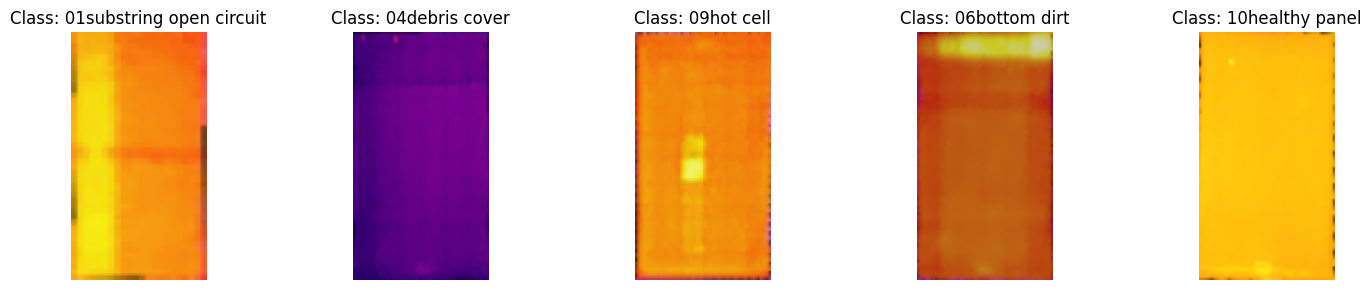


Visualizing class distribution across datasets:


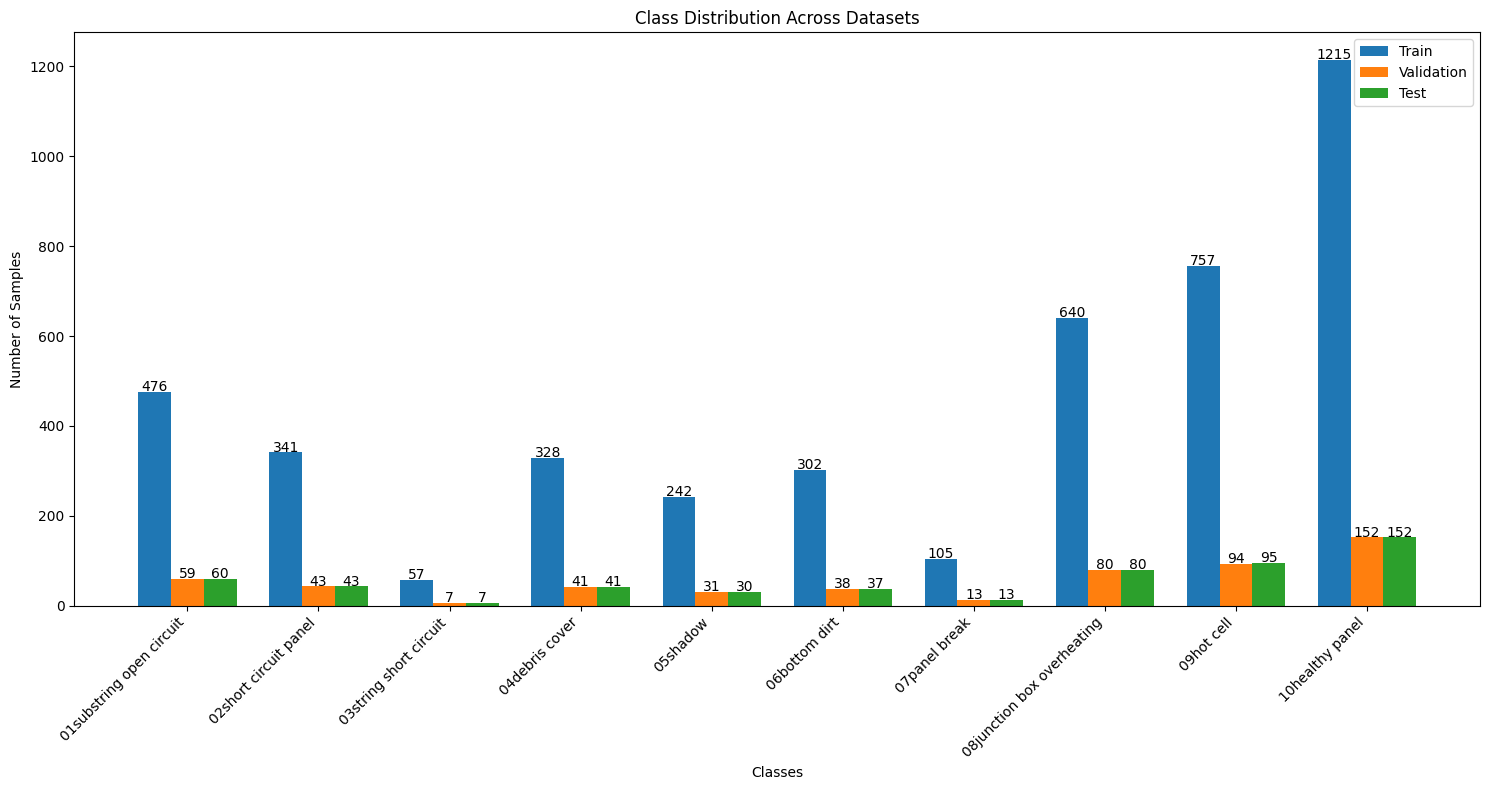


Starting model training with comprehensive performance tracking...

Training with AdamW optimizer, ENS weighting, and cosine scheduler

Model Summary
EfficientNetB0: Training approximately last 4 of 8 feature blocks and classifier (approx. 50.0% unfreezing)


C:\Users\tanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

Epoch 1/35: 100%|██████████| 139/139 [00:18<00:00,  7.46batch/s, accuracy=0.588, loss=1.25, lr=0.0005] 
<ipython-input-1-e65f97853b3b>:1222: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision


Epoch 1 completed in 18.65 seconds

Epoch 1/35
Train Loss: 1.5182, Train Accuracy: 0.5879
Learning Rate: 0.000500
Validation Loss: 0.9430, Validation Accuracy: 0.8199
Learning rate updated: 0.000500 → 0.000499
New best model saved at epoch 1 with validation loss: 0.9430


Epoch 2/35: 100%|██████████| 139/139 [00:17<00:00,  8.04batch/s, accuracy=0.796, loss=0.91, lr=0.000499] 


Epoch 2 completed in 17.32 seconds

Epoch 2/35
Train Loss: 1.0422, Train Accuracy: 0.7963
Learning Rate: 0.000499
Validation Loss: 0.9056, Validation Accuracy: 0.8346
Learning rate updated: 0.000499 → 0.000496
New best model saved at epoch 2 with validation loss: 0.9056


Epoch 3/35: 100%|██████████| 139/139 [00:17<00:00,  8.06batch/s, accuracy=0.865, loss=0.692, lr=0.000496]


Epoch 3 completed in 17.26 seconds

Epoch 3/35
Train Loss: 1.0346, Train Accuracy: 0.8651
Learning Rate: 0.000496
Validation Loss: 0.8048, Validation Accuracy: 0.8732
Learning rate updated: 0.000496 → 0.000491
New best model saved at epoch 3 with validation loss: 0.8048


Epoch 4/35: 100%|██████████| 139/139 [00:17<00:00,  8.01batch/s, accuracy=0.899, loss=0.682, lr=0.000491]


Epoch 4 completed in 17.36 seconds

Epoch 4/35
Train Loss: 0.8024, Train Accuracy: 0.8991
Learning Rate: 0.000491
Validation Loss: 0.8020, Validation Accuracy: 0.8787
Learning rate updated: 0.000491 → 0.000484
New best model saved at epoch 4 with validation loss: 0.8020


Epoch 5/35: 100%|██████████| 139/139 [00:17<00:00,  8.01batch/s, accuracy=0.917, loss=0.624, lr=0.000484]


Epoch 5 completed in 17.38 seconds

Epoch 5/35
Train Loss: 0.7338, Train Accuracy: 0.9166
Learning Rate: 0.000484
Validation Loss: 0.7916, Validation Accuracy: 0.8897
Learning rate updated: 0.000484 → 0.000475
New best model saved at epoch 5 with validation loss: 0.7916


Epoch 6/35: 100%|██████████| 139/139 [00:17<00:00,  8.00batch/s, accuracy=0.933, loss=0.606, lr=0.000475]


Epoch 6 completed in 17.41 seconds

Epoch 6/35
Train Loss: 0.6935, Train Accuracy: 0.9326
Learning Rate: 0.000475
Validation Loss: 0.7751, Validation Accuracy: 0.8879
Learning rate updated: 0.000475 → 0.000465
New best model saved at epoch 6 with validation loss: 0.7751


Epoch 7/35: 100%|██████████| 139/139 [00:17<00:00,  8.03batch/s, accuracy=0.947, loss=0.549, lr=0.000465]


Epoch 7 completed in 17.33 seconds

Epoch 7/35
Train Loss: 0.6572, Train Accuracy: 0.9472
Learning Rate: 0.000465
Validation Loss: 0.7916, Validation Accuracy: 0.8971
Learning rate updated: 0.000465 → 0.000452
No improvement in validation loss. Patience: 1/35


Epoch 8/35: 100%|██████████| 139/139 [00:17<00:00,  8.02batch/s, accuracy=0.949, loss=0.535, lr=0.000452]


Epoch 8 completed in 17.36 seconds

Epoch 8/35
Train Loss: 0.6445, Train Accuracy: 0.9485
Learning Rate: 0.000452
Validation Loss: 0.7975, Validation Accuracy: 0.8952
Learning rate updated: 0.000452 → 0.000438
No improvement in validation loss. Patience: 2/35


Epoch 9/35: 100%|██████████| 139/139 [00:17<00:00,  8.01batch/s, accuracy=0.954, loss=0.516, lr=0.000438]


Epoch 9 completed in 17.37 seconds

Epoch 9/35
Train Loss: 0.6329, Train Accuracy: 0.9541
Learning Rate: 0.000438
Validation Loss: 0.7771, Validation Accuracy: 0.8971
Learning rate updated: 0.000438 → 0.000423
No improvement in validation loss. Patience: 3/35


Epoch 10/35: 100%|██████████| 139/139 [00:17<00:00,  8.05batch/s, accuracy=0.966, loss=0.542, lr=0.000423]


Epoch 10 completed in 17.29 seconds

Epoch 10/35
Train Loss: 0.6012, Train Accuracy: 0.9656
Learning Rate: 0.000423
Validation Loss: 0.7625, Validation Accuracy: 0.9007
Learning rate updated: 0.000423 → 0.000406
New best model saved at epoch 10 with validation loss: 0.7625


Epoch 11/35: 100%|██████████| 139/139 [00:17<00:00,  7.82batch/s, accuracy=0.975, loss=0.589, lr=0.000406]


Epoch 11 completed in 17.81 seconds

Epoch 11/35
Train Loss: 0.5735, Train Accuracy: 0.9750
Learning Rate: 0.000406
Validation Loss: 0.7783, Validation Accuracy: 0.9026
Learning rate updated: 0.000406 → 0.000388
No improvement in validation loss. Patience: 1/35


Epoch 12/35: 100%|██████████| 139/139 [00:19<00:00,  7.28batch/s, accuracy=0.982, loss=0.514, lr=0.000388]


Epoch 12 completed in 19.14 seconds

Epoch 12/35
Train Loss: 0.5534, Train Accuracy: 0.9822
Learning Rate: 0.000388
Validation Loss: 0.8057, Validation Accuracy: 0.8934
Learning rate updated: 0.000388 → 0.000369
No improvement in validation loss. Patience: 2/35


Epoch 13/35: 100%|██████████| 139/139 [00:19<00:00,  7.04batch/s, accuracy=0.986, loss=0.511, lr=0.000369]


Epoch 13 completed in 19.76 seconds

Epoch 13/35
Train Loss: 0.5462, Train Accuracy: 0.9856
Learning Rate: 0.000369
Validation Loss: 0.7844, Validation Accuracy: 0.9062
Learning rate updated: 0.000369 → 0.000348
No improvement in validation loss. Patience: 3/35


Epoch 14/35: 100%|██████████| 139/139 [00:19<00:00,  7.30batch/s, accuracy=0.983, loss=0.522, lr=0.000348]


Epoch 14 completed in 19.06 seconds

Epoch 14/35
Train Loss: 0.5536, Train Accuracy: 0.9829
Learning Rate: 0.000348
Validation Loss: 0.8298, Validation Accuracy: 0.8879
Learning rate updated: 0.000348 → 0.000327
No improvement in validation loss. Patience: 4/35


Epoch 15/35: 100%|██████████| 139/139 [00:19<00:00,  7.30batch/s, accuracy=0.986, loss=0.504, lr=0.000327]


Epoch 15 completed in 19.06 seconds

Epoch 15/35
Train Loss: 0.5425, Train Accuracy: 0.9858
Learning Rate: 0.000327
Validation Loss: 0.7482, Validation Accuracy: 0.9118
Learning rate updated: 0.000327 → 0.000306
New best model saved at epoch 15 with validation loss: 0.7482


Epoch 16/35: 100%|██████████| 139/139 [00:19<00:00,  7.14batch/s, accuracy=0.986, loss=0.504, lr=0.000306]


Epoch 16 completed in 19.51 seconds

Epoch 16/35
Train Loss: 0.5416, Train Accuracy: 0.9856
Learning Rate: 0.000306
Validation Loss: 0.7193, Validation Accuracy: 0.9283
Learning rate updated: 0.000306 → 0.000284
New best model saved at epoch 16 with validation loss: 0.7193


Epoch 17/35: 100%|██████████| 139/139 [00:19<00:00,  7.24batch/s, accuracy=0.992, loss=0.504, lr=0.000284]


Epoch 17 completed in 19.22 seconds

Epoch 17/35
Train Loss: 0.5254, Train Accuracy: 0.9917
Learning Rate: 0.000284
Validation Loss: 0.7465, Validation Accuracy: 0.9210
Learning rate updated: 0.000284 → 0.000261
No improvement in validation loss. Patience: 1/35


Epoch 18/35: 100%|██████████| 139/139 [00:19<00:00,  7.29batch/s, accuracy=0.996, loss=0.505, lr=0.000261]


Epoch 18 completed in 19.09 seconds

Epoch 18/35
Train Loss: 0.5168, Train Accuracy: 0.9955
Learning Rate: 0.000261
Validation Loss: 0.7408, Validation Accuracy: 0.9210
Learning rate updated: 0.000261 → 0.000239
No improvement in validation loss. Patience: 2/35


Epoch 19/35: 100%|██████████| 139/139 [00:19<00:00,  7.23batch/s, accuracy=0.996, loss=0.618, lr=0.000239]


Epoch 19 completed in 19.28 seconds

Epoch 19/35
Train Loss: 0.5151, Train Accuracy: 0.9957
Learning Rate: 0.000239
Validation Loss: 0.7826, Validation Accuracy: 0.9099
Learning rate updated: 0.000239 → 0.000217
No improvement in validation loss. Patience: 3/35


Epoch 20/35: 100%|██████████| 139/139 [00:19<00:00,  7.14batch/s, accuracy=0.995, loss=0.503, lr=0.000217]


Epoch 20 completed in 19.50 seconds

Epoch 20/35
Train Loss: 0.5162, Train Accuracy: 0.9951
Learning Rate: 0.000217
Validation Loss: 0.7166, Validation Accuracy: 0.9265
Learning rate updated: 0.000217 → 0.000195
New best model saved at epoch 20 with validation loss: 0.7166


Epoch 21/35: 100%|██████████| 139/139 [00:19<00:00,  7.15batch/s, accuracy=0.998, loss=0.503, lr=0.000195]


Epoch 21 completed in 19.48 seconds

Epoch 21/35
Train Loss: 0.5073, Train Accuracy: 0.9975
Learning Rate: 0.000195
Validation Loss: 0.7148, Validation Accuracy: 0.9338
Learning rate updated: 0.000195 → 0.000173
New best model saved at epoch 21 with validation loss: 0.7148


Epoch 22/35: 100%|██████████| 139/139 [00:19<00:00,  7.18batch/s, accuracy=0.999, loss=0.503, lr=0.000173]


Epoch 22 completed in 19.40 seconds

Epoch 22/35
Train Loss: 0.5045, Train Accuracy: 0.9989
Learning Rate: 0.000173
Validation Loss: 0.7098, Validation Accuracy: 0.9338
Learning rate updated: 0.000173 → 0.000152
New best model saved at epoch 22 with validation loss: 0.7098


Epoch 23/35: 100%|██████████| 139/139 [00:19<00:00,  7.10batch/s, accuracy=0.999, loss=0.503, lr=0.000152]


Epoch 23 completed in 19.59 seconds

Epoch 23/35
Train Loss: 0.5036, Train Accuracy: 0.9987
Learning Rate: 0.000152
Validation Loss: 0.7089, Validation Accuracy: 0.9283
Learning rate updated: 0.000152 → 0.000132
New best model saved at epoch 23 with validation loss: 0.7089


Epoch 24/35: 100%|██████████| 139/139 [00:19<00:00,  7.22batch/s, accuracy=0.999, loss=0.503, lr=0.000132]


Epoch 24 completed in 19.30 seconds

Epoch 24/35
Train Loss: 0.5035, Train Accuracy: 0.9989
Learning Rate: 0.000132
Validation Loss: 0.7021, Validation Accuracy: 0.9357
Learning rate updated: 0.000132 → 0.000113
New best model saved at epoch 24 with validation loss: 0.7021


Epoch 25/35: 100%|██████████| 139/139 [00:19<00:00,  7.26batch/s, accuracy=1, loss=0.503, lr=0.000113]   


Epoch 25 completed in 19.19 seconds

Epoch 25/35
Train Loss: 0.5014, Train Accuracy: 0.9998
Learning Rate: 0.000113
Validation Loss: 0.7055, Validation Accuracy: 0.9338
Learning rate updated: 0.000113 → 0.000095
No improvement in validation loss. Patience: 1/35


Epoch 26/35: 100%|██████████| 139/139 [00:19<00:00,  7.23batch/s, accuracy=1, loss=0.503, lr=9.45e-5]


Epoch 26 completed in 19.25 seconds

Epoch 26/35
Train Loss: 0.5014, Train Accuracy: 1.0000
Learning Rate: 0.000095
Validation Loss: 0.7017, Validation Accuracy: 0.9357
Learning rate updated: 0.000095 → 0.000078
New best model saved at epoch 26 with validation loss: 0.7017


Epoch 27/35: 100%|██████████| 139/139 [00:19<00:00,  7.05batch/s, accuracy=1, loss=0.503, lr=7.77e-5]


Epoch 27 completed in 19.75 seconds

Epoch 27/35
Train Loss: 0.5014, Train Accuracy: 1.0000
Learning Rate: 0.000078
Validation Loss: 0.6976, Validation Accuracy: 0.9375
Learning rate updated: 0.000078 → 0.000062
New best model saved at epoch 27 with validation loss: 0.6976


Epoch 28/35: 100%|██████████| 139/139 [00:19<00:00,  7.22batch/s, accuracy=1, loss=0.503, lr=6.22e-5]


Epoch 28 completed in 19.32 seconds

Epoch 28/35
Train Loss: 0.5011, Train Accuracy: 1.0000
Learning Rate: 0.000062
Validation Loss: 0.6943, Validation Accuracy: 0.9357
Learning rate updated: 0.000062 → 0.000048
New best model saved at epoch 28 with validation loss: 0.6943


Epoch 29/35: 100%|██████████| 139/139 [00:19<00:00,  7.09batch/s, accuracy=1, loss=0.503, lr=4.82e-5]


Epoch 29 completed in 19.64 seconds

Epoch 29/35
Train Loss: 0.5011, Train Accuracy: 1.0000
Learning Rate: 0.000048
Validation Loss: 0.6928, Validation Accuracy: 0.9375
Learning rate updated: 0.000048 → 0.000036
New best model saved at epoch 29 with validation loss: 0.6928


Epoch 30/35: 100%|██████████| 139/139 [00:19<00:00,  7.26batch/s, accuracy=1, loss=0.503, lr=3.59e-5]


Epoch 30 completed in 19.17 seconds

Epoch 30/35
Train Loss: 0.5011, Train Accuracy: 1.0000
Learning Rate: 0.000036
Validation Loss: 0.6913, Validation Accuracy: 0.9375
Learning rate updated: 0.000036 → 0.000025
New best model saved at epoch 30 with validation loss: 0.6913


Epoch 31/35: 100%|██████████| 139/139 [00:19<00:00,  7.24batch/s, accuracy=1, loss=0.503, lr=2.52e-5]


Epoch 31 completed in 19.24 seconds

Epoch 31/35
Train Loss: 0.5011, Train Accuracy: 1.0000
Learning Rate: 0.000025
Validation Loss: 0.6903, Validation Accuracy: 0.9375
Learning rate updated: 0.000025 → 0.000016
New best model saved at epoch 31 with validation loss: 0.6903


Epoch 32/35: 100%|██████████| 139/139 [00:19<00:00,  7.24batch/s, accuracy=1, loss=0.503, lr=1.64e-5]


Epoch 32 completed in 19.24 seconds

Epoch 32/35
Train Loss: 0.5011, Train Accuracy: 1.0000
Learning Rate: 0.000016
Validation Loss: 0.6896, Validation Accuracy: 0.9375
Learning rate updated: 0.000016 → 0.000010
New best model saved at epoch 32 with validation loss: 0.6896


Epoch 33/35: 100%|██████████| 139/139 [00:19<00:00,  7.21batch/s, accuracy=1, loss=0.503, lr=9.5e-6]


Epoch 33 completed in 19.31 seconds

Epoch 33/35
Train Loss: 0.5011, Train Accuracy: 1.0000
Learning Rate: 0.000010
Validation Loss: 0.6893, Validation Accuracy: 0.9375
Learning rate updated: 0.000010 → 0.000005
New best model saved at epoch 33 with validation loss: 0.6893


Epoch 34/35: 100%|██████████| 139/139 [00:18<00:00,  7.60batch/s, accuracy=1, loss=0.503, lr=4.51e-6]


Epoch 34 completed in 18.32 seconds

Epoch 34/35
Train Loss: 0.5011, Train Accuracy: 1.0000
Learning Rate: 0.000005
Validation Loss: 0.6891, Validation Accuracy: 0.9375
Learning rate updated: 0.000005 → 0.000002
New best model saved at epoch 34 with validation loss: 0.6891


Epoch 35/35: 100%|██████████| 139/139 [00:17<00:00,  7.93batch/s, accuracy=1, loss=0.503, lr=1.51e-6]


Epoch 35 completed in 17.54 seconds

Epoch 35/35
Train Loss: 0.5011, Train Accuracy: 1.0000
Learning Rate: 0.000002
Validation Loss: 0.6891, Validation Accuracy: 0.9375
Learning rate updated: 0.000002 → 0.000000
No improvement in validation loss. Patience: 1/35

Total training time: 716.91 seconds
Final model saved at epoch 35
Loaded best model from epoch 34 for evaluation

LOADING BEST MODEL FOR TEST EVALUATION
Loading best model from: C:/Users/tanan/Downloads/anchee_fyp2/efficientnetb0_pv_fault_best2.pth
Recreating criterion with saved class weights...
Criterion weights loaded: tensor([0.9939, 0.9939, 1.0503, 0.9939, 0.9939, 0.9939, 0.9985, 0.9939, 0.9939,
        0.9939], device='cuda:0')
Successfully loaded best model from epoch 34
Best validation loss: 0.6891
Best validation accuracy: 0.9375

BENCHMARKING BEST MODEL - DETAILED INFERENCE TIMING
Running original benchmark...

FLOPs Breakdown:
| module                  | #parameters or shape   | #flops     |
|:-----------------------

<ipython-input-1-e65f97853b3b>:1222: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision


Test Performance (Best Model - Epoch 34):
Test Loss: 0.4687, Test Accuracy: 0.9032

Double-checking test results...
Test Results Verification:
Test Loss: 0.4687, Test Accuracy: 0.9032
✓ Test predictions are consistent

FINAL MODEL PERFORMANCE EVALUATION ON TEST SET
Loading final model from: C:/Users/tanan/Downloads/anchee_fyp2/efficientnetb0_pv_fault_final.pth


C:\Users\tanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNetB0: Training approximately last 4 of 8 feature blocks and classifier (approx. 50.0% unfreezing)

BENCHMARKING FINAL MODEL - DETAILED INFERENCE TIMING
Running original benchmark...

FLOPs Breakdown:
| module                  | #parameters or shape   | #flops     |
|:------------------------|:-----------------------|:-----------|
| model                   | 5.852M                 | 0.402G     |
|  features               |  4.008M                |  0.4G      |
|   features.0            |   0.928K               |   11.641M  |
|    features.0.0         |    0.864K              |    10.838M |
|    features.0.1         |    64                  |    0.803M  |
|   features.1.0.block    |   1.448K               |   11.641M  |
|    features.1.0.block.0 |    0.352K              |    4.415M  |
|    features.1.0.block.1 |    0.552K              |    0.402M  |
|    features.1.0.block.2 |    0.544K              |    6.824M  |
|   features.2            |   16.714K              |   60.816M  

<ipython-input-1-e65f97853b3b>:1222: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision


Final Model Test Performance (Epoch 35):
Final Test Loss: 0.4688, Final Test Accuracy: 0.9032

Final Model - Detailed Classification Report:
                            precision    recall  f1-score   support

  01substring open circuit     0.9828    0.9500    0.9661        60
     02short circuit panel     0.9773    1.0000    0.9885        43
    03string short circuit     0.6000    0.4286    0.5000         7
            04debris cover     0.8529    0.7073    0.7733        41
                  05shadow     0.8929    0.8333    0.8621        30
             06bottom dirt     0.8710    0.7297    0.7941        37
             07panel break     0.9167    0.8462    0.8800        13
08junction box overheating     0.9873    0.9750    0.9811        80
                09hot cell     0.8627    0.9263    0.8934        95
           10healthy panel     0.8667    0.9408    0.9022       152

                  accuracy                         0.9032       558
                 macro avg     0.8810    

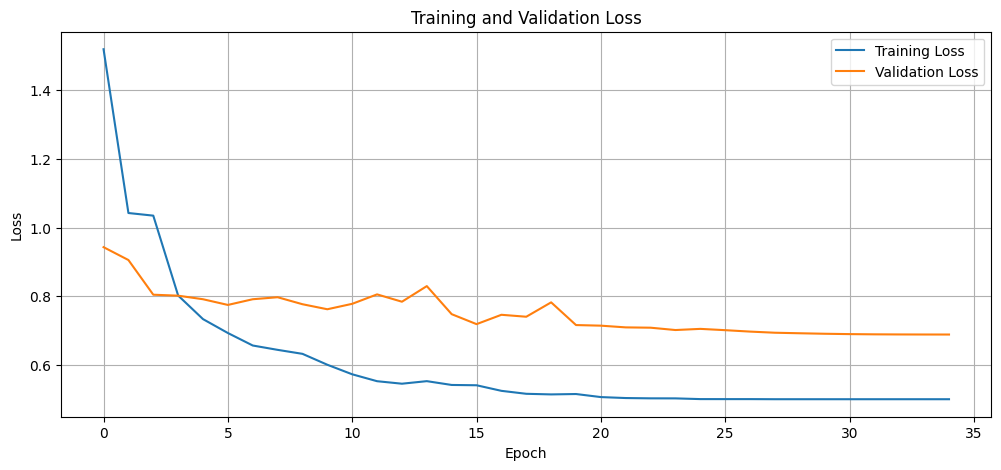

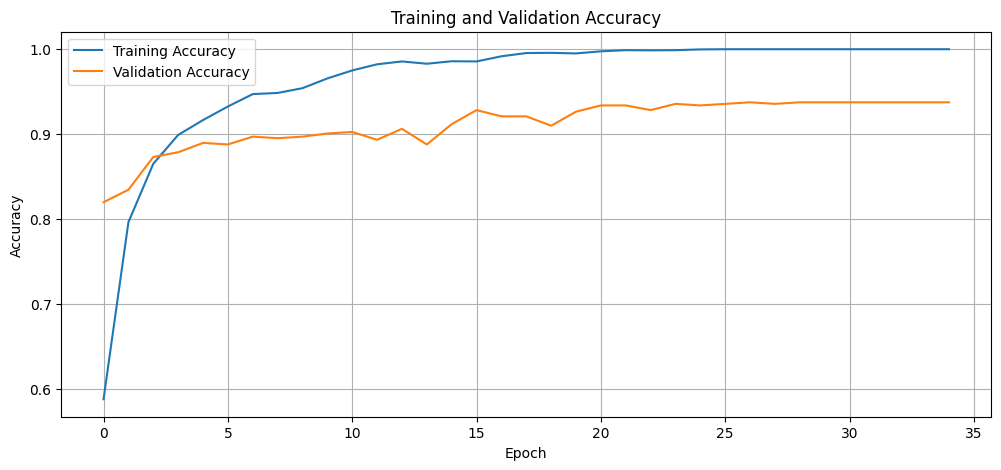

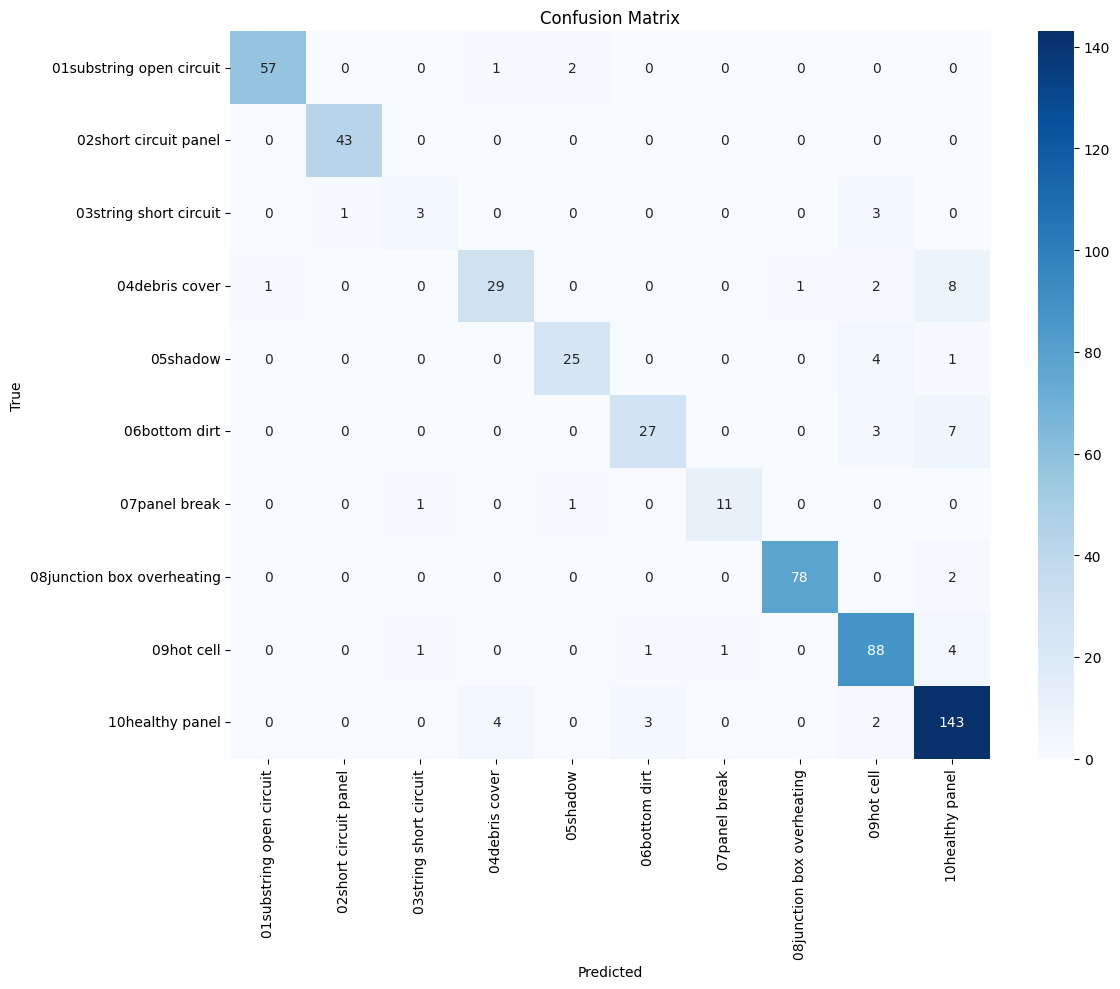


Classification Report:
                            precision    recall  f1-score   support

  01substring open circuit       0.98      0.95      0.97        60
     02short circuit panel       0.98      1.00      0.99        43
    03string short circuit       0.60      0.43      0.50         7
            04debris cover       0.85      0.71      0.77        41
                  05shadow       0.89      0.83      0.86        30
             06bottom dirt       0.87      0.73      0.79        37
             07panel break       0.92      0.85      0.88        13
08junction box overheating       0.99      0.97      0.98        80
                09hot cell       0.86      0.93      0.89        95
           10healthy panel       0.87      0.94      0.90       152

                  accuracy                           0.90       558
                 macro avg       0.88      0.83      0.85       558
              weighted avg       0.90      0.90      0.90       558


Visualizing computat

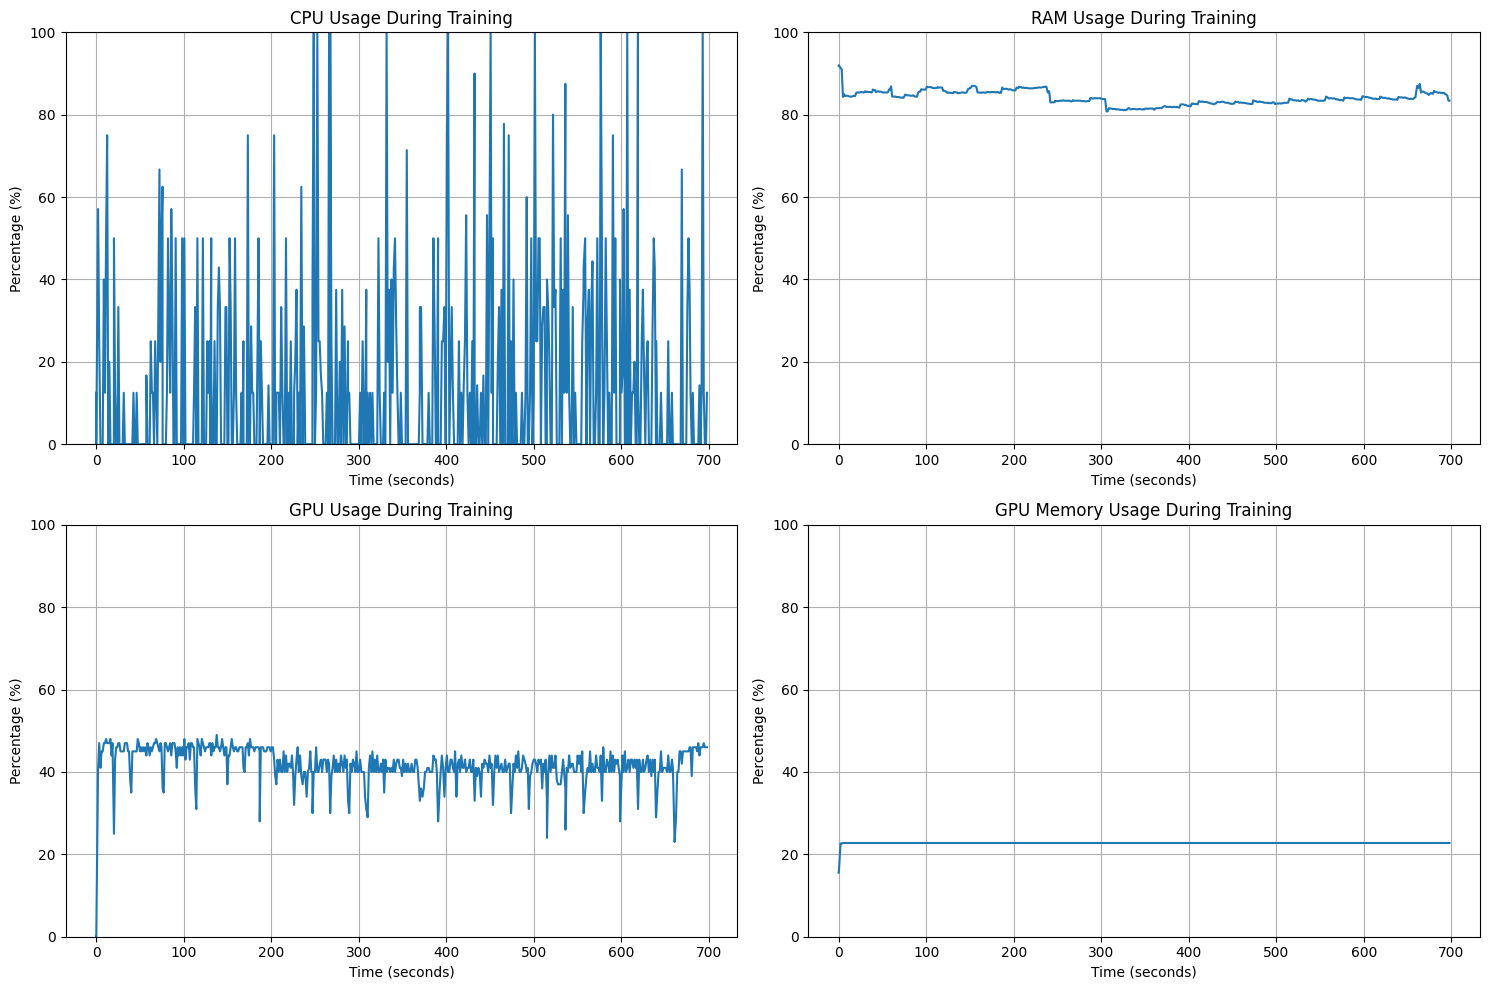


Computational Efficiency Metrics:
Total Training Time: 740.42 seconds
Training Set Size: 4463 samples
Test Set Size: 558 samples
Average CPU Usage: 14.77%
Average RAM Usage: 84.16%
Average GPU Usage: 41.49%
Average GPU Memory Usage: 22.73%

Saving final model with performance metrics...


<ipython-input-1-e65f97853b3b>:1222: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision


Final model saved with metrics: C:/Users/tanan/Downloads/anchee_fyp2\efficientnetb0_pv_fault_final.pth
Test accuracy: 0.9032
Saved model size: 22.63 MB

Training and evaluation complete!


In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import time
from datetime import datetime
from PIL import ImageOps
import torch.nn.functional as F
import psutil
import pandas as pd
import gc
from pynvml import *
from torchsummary import summary
from sklearn.model_selection import train_test_split
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
import random

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ----------------------------
# Benchmarking Utilities
# ----------------------------

def calculate_flops(model, input_size=(1, 3, 224, 224)):
    """Calculate FLOPs for the model with better operator support"""
    from fvcore.nn import FlopCountAnalysis, flop_count_table
    
    model.eval()
    device = next(model.parameters()).device
    inputs = torch.randn(input_size).to(device)
    
    # Calculate FLOPs
    flops = FlopCountAnalysis(model, inputs)
    
    # Print detailed table (optional)
    print("\nFLOPs Breakdown:")
    print(flop_count_table(flops))
    
    return flops.total()

def benchmark_model(model, test_loader, device, num_runs=100):
    """Enhanced benchmarking with more metrics"""
    model.eval()
    times = []
    flops = None
    
    try:
        # Calculate FLOPs first
        flops = calculate_flops(model)
    except Exception as e:
        print(f"\nFLOPs calculation warning: {str(e)}")
        flops = None
    
    # Create dummy input with same shape as actual data
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    
    with torch.no_grad():
        # Warmup
        for _ in range(10):
            _ = model(dummy_input)
        
        # Benchmark
        for _ in range(num_runs):
            start = time.time()
            _ = model(dummy_input)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            times.append(time.time() - start)
    
    # Memory usage
    if device.type == 'cuda':
        torch.cuda.synchronize()
        mem_stats = {
            'allocated_mb': torch.cuda.memory_allocated(device) / 1024**2,
            'reserved_mb': torch.cuda.memory_reserved(device) / 1024**2,
            'max_allocated_mb': torch.cuda.max_memory_allocated(device) / 1024**2
        }
    else:
        process = psutil.Process()
        mem_info = process.memory_info()
        mem_stats = {
            'rss_mb': mem_info.rss / 1024**2,
            'vms_mb': mem_info.vms / 1024**2
        }
    
    return {
        'avg_inference_time': np.mean(times),
        'fps': 1/np.mean(times),
        'std_dev': np.std(times),
        'flops': flops,
        'flops_g': flops / 1e9 if flops else None,
        **mem_stats
    }

def get_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

def count_parameters(model):
    """Count total number of trainable parameters in millions"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6

def get_memory_usage(device):
    """Get current memory usage in MB"""
    if device.type == 'cuda':
        torch.cuda.synchronize()
        return {
            'allocated_memory_mb': torch.cuda.memory_allocated(device) / 1024**2,
            'reserved_memory_mb': torch.cuda.memory_reserved(device) / 1024**2
        }
    else:
        process = psutil.Process()
        return {'ram_usage_mb': process.memory_info().rss / 1024**2}

def get_detailed_memory_usage(device):
    """Get detailed memory usage statistics"""
    if device.type == 'cuda':
        torch.cuda.synchronize()
        return {
            'allocated_memory_mb': torch.cuda.memory_allocated(device) / 1024**2,
            'reserved_memory_mb': torch.cuda.memory_reserved(device) / 1024**2,
            'max_allocated_mb': torch.cuda.max_memory_allocated(device) / 1024**2,
            'max_reserved_mb': torch.cuda.max_memory_reserved(device) / 1024**2
        }
    else:
        process = psutil.Process()
        mem_info = process.memory_info()
        return {
            'ram_usage_mb': mem_info.rss / 1024**2,
            'virtual_memory_mb': mem_info.vms / 1024**2
        }

# ----------------------------
# Performance Logger Class
# ----------------------------

class PerformanceLogger:
    def __init__(self, experiment_name="PV_Fault_Detection"):
        self.experiment_name = experiment_name
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Create the base directory if it doesn't exist
        base_log_dir = "C:/Users/tanan/Downloads/anchee_fyp2/performance_logs"
        os.makedirs(base_log_dir, exist_ok=True)
        
        # Create the experiment-specific directory
        self.log_dir = os.path.join(base_log_dir, f"{experiment_name}_{self.timestamp}")
        os.makedirs(self.log_dir, exist_ok=True)
        
        # Initialize data structures
        self.epoch_metrics = []
        self.system_metrics = []
        self.final_metrics = {}
        self.confusion_matrix = None
        self.classification_report = None
        
    def log_epoch(self, epoch, train_loss, train_acc, val_loss, val_acc, lr):
        """Log metrics for each epoch"""
        epoch_data = {
            'epoch': epoch + 1,
            'train_loss': float(train_loss),
            'train_accuracy': float(train_acc),
            'val_loss': float(val_loss),
            'val_accuracy': float(val_acc),
            'learning_rate': float(lr),
            'timestamp': datetime.now().isoformat()
        }
        self.epoch_metrics.append(epoch_data)
        
    def log_system(self, cpu, ram, gpu=None, gpu_mem=None):
        """Log system metrics"""
        sys_data = {
            'timestamp': datetime.now().isoformat(),
            'cpu_usage': float(cpu),
            'ram_usage': float(ram),
            'gpu_usage': float(gpu) if gpu is not None else None,
            'gpu_memory': float(gpu_mem) if gpu_mem is not None else None
        }
        self.system_metrics.append(sys_data)
        
    def log_final_metrics(self, metrics_dict):
        """Log final metrics"""
        self.final_metrics = metrics_dict
        
    def log_classification_report(self, report_dict):
        """Log classification report"""
        self.classification_report = report_dict
        
    def log_confusion_matrix(self, cm, class_names):
        """Log confusion matrix"""
        self.confusion_matrix = {
            'matrix': cm.tolist(),
            'class_names': class_names
        }
    
    def save_all(self):
        """Save all logged data to files"""
        try:
            # Ensure directory exists
            os.makedirs(self.log_dir, exist_ok=True)
            
            # Save epoch metrics
            epoch_path = os.path.join(self.log_dir, "epoch_metrics.json")
            with open(epoch_path, 'w') as f:
                json.dump(self.epoch_metrics, f, indent=4)
                
            # Save system metrics
            system_path = os.path.join(self.log_dir, "system_metrics.json")
            with open(system_path, 'w') as f:
                json.dump(self.system_metrics, f, indent=4)
                
            # Save final metrics
            final_path = os.path.join(self.log_dir, "final_metrics.json")
            with open(final_path, 'w') as f:
                json.dump(self.final_metrics, f, indent=4)
                
            # Save classification report
            if self.classification_report:
                report_json_path = os.path.join(self.log_dir, "classification_report.json")
                with open(report_json_path, 'w') as f:
                    json.dump(self.classification_report, f, indent=4)
                
                report_txt_path = os.path.join(self.log_dir, "classification_report.txt")
                with open(report_txt_path, 'w') as f:
                    f.write(classification_report_to_text(self.classification_report))
                    
            # Save confusion matrix
            if self.confusion_matrix:
                cm_path = os.path.join(self.log_dir, "confusion_matrix.json")
                with open(cm_path, 'w') as f:
                    json.dump(self.confusion_matrix, f, indent=4)
                
                # Save confusion matrix plot
                plt.figure(figsize=(12, 10))
                sns.heatmap(self.confusion_matrix['matrix'], annot=True, fmt='d', cmap='Blues',
                            xticklabels=self.confusion_matrix['class_names'],
                            yticklabels=self.confusion_matrix['class_names'])
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.title('Confusion Matrix')
                plt.tight_layout()
                cm_plot_path = os.path.join(self.log_dir, "confusion_matrix.png")
                plt.savefig(cm_plot_path)
                plt.close()
                
            # Save training curves
            if len(self.epoch_metrics) > 0:
                self._save_training_curves()
                
            print(f"\nAll performance metrics saved to: {self.log_dir}")
            
        except Exception as e:
            print(f"\nError saving performance metrics: {str(e)}")
        
    def _save_training_curves(self):
        """Save training and validation curves"""
        epochs = [m['epoch'] for m in self.epoch_metrics]
        train_loss = [m['train_loss'] for m in self.epoch_metrics]
        val_loss = [m['val_loss'] for m in self.epoch_metrics]
        train_acc = [m['train_accuracy'] for m in self.epoch_metrics]
        val_acc = [m['val_accuracy'] for m in self.epoch_metrics]
        
        # Loss curve
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, train_loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{self.log_dir}/loss_curve.png")
        plt.close()
        
        # Accuracy curve
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, train_acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{self.log_dir}/accuracy_curve.png")
        plt.close()
        
        # Combined curve
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        ax1.plot(epochs, train_loss, label='Training Loss')
        ax1.plot(epochs, val_loss, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(epochs, train_acc, label='Training Accuracy')
        ax2.plot(epochs, val_acc, label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(f"{self.log_dir}/training_curves.png")
        plt.close()

def classification_report_to_text(report_dict):
    """Convert classification report dictionary to text format"""
    text = "\nClassification Report:\n"
    text += f"{'':<15}{'precision':>10}{'recall':>10}{'f1-score':>10}{'support':>10}\n"
    
    # Add metrics for each class
    for class_name in report_dict:
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        metrics = report_dict[class_name]
        text += f"{class_name:<15}{metrics['precision']:>10.2f}{metrics['recall']:>10.2f}{metrics['f1-score']:>10.2f}{metrics['support']:>10}\n"
    
    # Add overall accuracy
    if 'accuracy' in report_dict:
        text += f"\n{'accuracy':<15}{'':30}{report_dict['accuracy']:>10.2f}\n"
    
    # Add macro and weighted averages
    for avg_type in ['macro avg', 'weighted avg']:
        if avg_type in report_dict:
            metrics = report_dict[avg_type]
            text += f"{avg_type:<15}{metrics['precision']:>10.2f}{metrics['recall']:>10.2f}{metrics['f1-score']:>10.2f}{metrics['support']:>10}\n"
    
    return text

# ----------------------------
# System Monitoring Class
# ----------------------------

class SystemMonitor:
    def __init__(self):
        self.cpu_usages = []
        self.ram_usages = []
        self.gpu_usages = []
        self.gpu_memories = []
        self.timestamps = []
        self.gpu_available = False
        
        # Initialize GPU monitoring if available
        try:
            nvmlInit()
            self.gpu_available = True
            self.gpu_handles = [nvmlDeviceGetHandleByIndex(i) for i in range(nvmlDeviceGetCount())]
        except:
            self.gpu_available = False
        
    def record(self):
        """Record current system metrics"""
        # Record timestamp
        self.timestamps.append(time.time())
        
        # CPU and RAM usage
        self.cpu_usages.append(psutil.cpu_percent())
        self.ram_usages.append(psutil.virtual_memory().percent)
        
        # GPU usage if available
        if self.gpu_available:
            try:
                gpu_usage = nvmlDeviceGetUtilizationRates(self.gpu_handles[0]).gpu
                gpu_mem = nvmlDeviceGetMemoryInfo(self.gpu_handles[0]).used / nvmlDeviceGetMemoryInfo(self.gpu_handles[0]).total * 100
                self.gpu_usages.append(gpu_usage)
                self.gpu_memories.append(gpu_mem)
            except:
                self.gpu_usages.append(0)
                self.gpu_memories.append(0)
        else:
            self.gpu_usages.append(0)
            self.gpu_memories.append(0)
    
    def get_summary(self):
        """Get summary statistics of system metrics"""
        summary = {
            'cpu': {
                'mean': float(np.mean(self.cpu_usages)),
                'max': float(np.max(self.cpu_usages)),
                'min': float(np.min(self.cpu_usages)),
                'std': float(np.std(self.cpu_usages))
            },
            'ram': {
                'mean': float(np.mean(self.ram_usages)),
                'max': float(np.max(self.ram_usages)),
                'min': float(np.min(self.ram_usages)),
                'std': float(np.std(self.ram_usages))
            }
        }
        
        if any(usage > 0 for usage in self.gpu_usages):
            summary['gpu'] = {
                'usage_mean': float(np.mean(self.gpu_usages)),
                'usage_max': float(np.max(self.gpu_usages)),
                'usage_min': float(np.min(self.gpu_usages)),
                'usage_std': float(np.std(self.gpu_usages)),
                'memory_mean': float(np.mean(self.gpu_memories)),
                'memory_max': float(np.max(self.gpu_memories)),
                'memory_min': float(np.min(self.gpu_memories)),
                'memory_std': float(np.std(self.gpu_memories))
            }
        
        return summary
    
    def save_metrics_plot(self, save_path):
        """Save system metrics visualization"""
        plt.figure(figsize=(15, 10))
        
        # Calculate relative timestamps
        if len(self.timestamps) > 0:
            relative_times = [t - self.timestamps[0] for t in self.timestamps]
        else:
            relative_times = []
        
        # CPU Usage
        plt.subplot(2, 2, 1)
        plt.plot(relative_times, self.cpu_usages, label='CPU Usage')
        plt.title('CPU Usage During Training')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        
        # RAM Usage
        plt.subplot(2, 2, 2)
        plt.plot(relative_times, self.ram_usages, label='RAM Usage')
        plt.title('RAM Usage During Training')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        
        # GPU Usage (if available)
        if any(usage > 0 for usage in self.gpu_usages):
            plt.subplot(2, 2, 3)
            plt.plot(relative_times, self.gpu_usages, label='GPU Usage')
            plt.title('GPU Usage During Training')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Percentage (%)')
            plt.ylim(0, 100)
            plt.grid(True)
            
            plt.subplot(2, 2, 4)
            plt.plot(relative_times, self.gpu_memories, label='GPU Memory')
            plt.title('GPU Memory Usage During Training')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Percentage (%)')
            plt.ylim(0, 100)
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()

# ----------------------------
# Data Preparation Functions
# ----------------------------

def preparing_data():
    """Prepare and load the dataset with correct train/validation/test split (80/10/10)"""
    # Define data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val_test': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Set the full data directory
    data_dir = "C:/Users/tanan/Downloads/anchee_fyp2/PVF_10/PVF_10_Processed"

    # Create dataset from the full directory with no transform
    print("\nLoading full dataset...")
    full_dataset = PVFaultDataset(data_dir, transform=None)

    # First split into train and temp (80/20)
    train_indices, temp_indices = train_test_split(
        list(range(len(full_dataset))), 
        test_size=0.2,
        stratify=[full_dataset.labels[i] for i in range(len(full_dataset))],
        random_state=42
    )
    
    # Further split temp into validation and test (10/10 of the original dataset)
    val_indices, test_indices = train_test_split(
        temp_indices,
        test_size=0.5,
        stratify=[full_dataset.labels[i] for i in temp_indices],
        random_state=42
    )

    # Create datasets with transforms
    train_dataset = PVFaultDataset(data_dir, transform=data_transforms['train'])
    train_dataset.img_paths = [full_dataset.img_paths[i] for i in train_indices]
    train_dataset.labels = [full_dataset.labels[i] for i in train_indices]

    val_dataset = PVFaultDataset(data_dir, transform=data_transforms['val_test'])
    val_dataset.img_paths = [full_dataset.img_paths[i] for i in val_indices]
    val_dataset.labels = [full_dataset.labels[i] for i in val_indices]

    test_dataset = PVFaultDataset(data_dir, transform=data_transforms['val_test'])
    test_dataset.img_paths = [full_dataset.img_paths[i] for i in test_indices]
    test_dataset.labels = [full_dataset.labels[i] for i in test_indices]

    # Print dataset sizes
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, drop_last=False)

    # Get class information
    class_names = full_dataset.classes
    num_classes = len(class_names)
    print(f"\nNumber of classes: {num_classes}")
    print(f"Class names: {class_names}")

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, class_names, num_classes

# Dataset class
class PVFaultDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.img_paths = []
        self.labels = []
        
        # Load all image paths and their labels
        for class_name in self.classes:
            class_dir = os.path.join(img_dir, class_name)
            class_count = 0
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png', '.tif')):
                    self.img_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])
                    class_count += 1
            print(f"Class {class_name}: {class_count} images")
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # Apply transform here consistently
        if self.transform:
            image = self.transform(image)
        else:
            # Ensure tensor conversion even without transform
            image = transforms.ToTensor()(image)
            
        return image, label

# ----------------------------
# Visualization Functions
# ----------------------------

def visualize_samples(dataset, num_samples=5):
    """Visualize sample images from the dataset"""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    # Get class names from the original dataset if it's a TransformDataset
    if hasattr(dataset, 'subset') and hasattr(dataset.subset.dataset, 'classes'):
        classes = dataset.subset.dataset.classes
    elif hasattr(dataset, 'classes'):
        classes = dataset.classes
    else:
        # Fallback if classes can't be found
        classes = [f"Class {i}" for i in range(10)]  # Generic class names
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {classes[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_results(train_losses, train_accuracies, val_losses, val_accuracies, all_preds, all_labels, class_names):
    """Visualize training results and metrics"""
    # Figure 1: Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Figure 2: Training and Validation Accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Figure 3: Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

def visualize_computational_metrics(monitor, total_time, train_size, test_size):
    """Visualize computational efficiency metrics"""
    plt.figure(figsize=(15, 10))
    
    # Calculate relative timestamps
    if len(monitor.timestamps) > 0:
        relative_times = [t - monitor.timestamps[0] for t in monitor.timestamps]
    else:
        relative_times = []
    
    # CPU Usage
    plt.subplot(2, 2, 1)
    plt.plot(relative_times, monitor.cpu_usages, label='CPU Usage')
    plt.title('CPU Usage During Training')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(True)
    
    # RAM Usage
    plt.subplot(2, 2, 2)
    plt.plot(relative_times, monitor.ram_usages, label='RAM Usage')
    plt.title('RAM Usage During Training')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(True)
    
    # GPU Usage (if available)
    if any(usage > 0 for usage in monitor.gpu_usages):
        plt.subplot(2, 2, 3)
        plt.plot(relative_times, monitor.gpu_usages, label='GPU Usage')
        plt.title('GPU Usage During Training')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        
        plt.subplot(2, 2, 4)
        plt.plot(relative_times, monitor.gpu_memories, label='GPU Memory')
        plt.title('GPU Memory Usage During Training')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nComputational Efficiency Metrics:")
    print(f"Total Training Time: {total_time:.2f} seconds")
    print(f"Training Set Size: {train_size} samples")
    print(f"Test Set Size: {test_size} samples")
    print(f"Average CPU Usage: {np.mean(monitor.cpu_usages):.2f}%")
    print(f"Average RAM Usage: {np.mean(monitor.ram_usages):.2f}%")
    
    if any(usage > 0 for usage in monitor.gpu_usages):
        print(f"Average GPU Usage: {np.mean(monitor.gpu_usages):.2f}%")
        print(f"Average GPU Memory Usage: {np.mean(monitor.gpu_memories):.2f}%")

def visualize_class_distribution(train_dataset, val_dataset, test_dataset, class_names):
    """Visualize class distribution across train, val, and test sets in a single bar chart"""
    # Get counts for each dataset
    train_counts = np.zeros(len(class_names))
    val_counts = np.zeros(len(class_names))
    test_counts = np.zeros(len(class_names))
    
    # Count samples in train set
    for _, label in train_dataset:
        train_counts[label] += 1
    
    # Count samples in validation set
    for _, label in val_dataset:
        val_counts[label] += 1
    
    # Count samples in test set
    for _, label in test_dataset:
        test_counts[label] += 1
    
    # Create figure
    plt.figure(figsize=(15, 8))
    bar_width = 0.25
    index = np.arange(len(class_names))
    
    # Plot bars for each dataset
    plt.bar(index, train_counts, bar_width, label='Train')
    plt.bar(index + bar_width, val_counts, bar_width, label='Validation')
    plt.bar(index + 2*bar_width, test_counts, bar_width, label='Test')
    
    # Customize plot
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution Across Datasets')
    plt.xticks(index + bar_width, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    
    # Add exact numbers on top of bars
    for i in range(len(class_names)):
        plt.text(i, train_counts[i] + 2, str(int(train_counts[i])), ha='center')
        plt.text(i + bar_width, val_counts[i] + 2, str(int(val_counts[i])), ha='center')
        plt.text(i + 2*bar_width, test_counts[i] + 2, str(int(test_counts[i])), ha='center')
    
    plt.show()

# ----------------------------
# Model Functions
# ----------------------------

def create_efficientnetb0_model(num_classes, unfreeze_percentage=0.50):
    """
    Create EfficientNetB0 with a configurable unfreeze percentage and an enhanced classifier head.

    Args:
        num_classes (int): The number of output classes for the classifier.
        unfreeze_percentage (float): The approximate percentage of the backbone to unfreeze
                                     from the end (e.g., 0.25 for last 25%, 0.5 for last 50%).
                                     Set to 1.0 to unfreeze all layers.
    Returns:
        torch.nn.Module: The configured EfficientNetB0 model.
    """
    model = models.efficientnet_b0(pretrained=True)
    
    # EfficientNetB0 has 8 blocks in its features (0-7)
    total_feature_blocks = 8
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Determine which blocks to unfreeze based on the percentage
    num_unfreeze_blocks = int(total_feature_blocks * unfreeze_percentage)
    if num_unfreeze_blocks == 0 and unfreeze_percentage > 0: # Ensure at least one block if percentage > 0
        num_unfreeze_blocks = 1 
    
    start_unfreeze_block_idx = total_feature_blocks - num_unfreeze_blocks
    
    # Unfreeze specific blocks and the classifier
    for name, param in model.named_parameters():
        # Unfreeze blocks from 'start_unfreeze_block_idx' to 'total_feature_blocks - 1'
        if any(f"features.{i}" in name for i in range(start_unfreeze_block_idx, total_feature_blocks)) or "classifier" in name:
            param.requires_grad = True
            
    print(f"EfficientNetB0: Training approximately last {num_unfreeze_blocks} of {total_feature_blocks} feature blocks and classifier (approx. {100*num_unfreeze_blocks/total_feature_blocks:.1f}% unfreezing)")
    
    # Enhanced classifier head (matching your ResNet/MobileNetV2 implementation)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    
    return model

def report_model_params(model, model_name="EfficientNetB0"):
    """Analyzes and reports model's trainable vs total parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    
    print(f"\n{model_name} Parameter Analysis:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")
    print(f"Frozen parameters: {frozen_params:,} ({frozen_params/total_params:.2%})")
    
    return {
        "model": model_name,
        "total_params": total_params,
        "trainable_params": trainable_params,
        "frozen_params": frozen_params,
        "trainable_percentage": trainable_params/total_params
    }

def initialize_model(num_classes, device):
    """Initialize the model and move it to the specified device"""
    model_name = EfficientNetB0
    print(f"\nInitializing {model_name}...")
    
    model = create_efficientnetb0_model(num_classes, unfreeze_percentage=0.50)
    
    # Report parameter statistics
    param_stats = report_model_params(model, model_name)
    
    model = model.to(device)
    return model, param_stats

# ----------------------------
# Training Utilities
# ----------------------------

def get_class_weights(dataset, num_classes, method='ens', beta=0.95):
    """
    Calculate class weights using different methods
    
    Args:
        dataset: Training dataset
        num_classes: Number of classes
        method: Weighting method ('ins', 'isns', 'ens', 'equal')
        beta: Beta parameter for ENS method
    
    Returns:
        weights_tensor: Tensor of class weights
        raw_weights: Raw weights before normalization
        balanced_weights: Final normalized weights
    """
    # Get class counts
    class_counts = np.zeros(num_classes)
    for _, label in dataset:
        class_counts[label] += 1

    samples_per_class = class_counts.astype(int)
    
    # Check for empty classes
    if np.any(samples_per_class == 0):
        print(f"Warning: Found classes with 0 samples: {np.where(samples_per_class == 0)[0]}")
        # Handle empty classes by setting minimum count to 1
        samples_per_class = np.maximum(samples_per_class, 1)

    # Calculate method-specific raw weights
    if method == 'ins':
        # Inverse Number of Samples: weight_c = 1 / n_c
        raw_weights = 1.0 / samples_per_class
        
    elif method == 'isns':
        # Inverse Square Root Number of Samples: weight_c = 1 / sqrt(n_c)
        raw_weights = 1.0 / np.sqrt(samples_per_class)
        
    elif method == 'ens':
        # Effective Number of Samples: weight_c = 1 / effective_num
        effective_num = (1.0 - np.power(beta, samples_per_class)) / (1.0 - beta)
        raw_weights = 1.0 / effective_num
        
    elif method == 'equal':
        # Equal weights (no reweighting)
        raw_weights = np.ones(num_classes)
        
    else:
        raise ValueError(f"Unknown method: {method}. Available: ['ins', 'isns', 'ens', 'equal']")

    # Normalize weights to sum to num_classes (standard practice)
    balanced_weights = raw_weights / np.sum(raw_weights) * num_classes
    
    # Convert to tensor
    weights_tensor = torch.tensor(balanced_weights, dtype=torch.float32)

    print(f"\nClass Weighting Method: {method.upper()}")
    print(f"Class counts: {samples_per_class}")
    print(f"Raw weights: {raw_weights}")
    print(f"Balanced weights: {balanced_weights}")
    print(f"Sum of balanced weights: {np.sum(balanced_weights):.4f}")

    return weights_tensor, raw_weights, balanced_weights

def visualize_class_weights(class_names, class_counts, raw_weights, final_weights, logger=None, method='ens'):
    """Plot the complete transformation chain clearly"""
    plt.figure(figsize=(20, 6))

    # Step 1: Original distribution (normalized to probabilities)
    original_probs = class_counts / np.sum(class_counts)
    
    # Step 2: Raw weights (method-specific, not normalized)
    # Step 3: Final weights (normalized)
    final_probs = final_weights / np.sum(final_weights)

    print(f"\nComplete Transformation Chain ({method.upper()} method):")
    print(f"{'Class':<15}{'Original Count':>15}{'Original Prob':>15}{'Raw Weight':>15}{'Final Weight':>15}{'Final Prob':>15}")
    print("-" * 90)
    for i, name in enumerate(class_names):
        print(f"{name:<15}{class_counts[i]:>15.0f}{original_probs[i]:>15.4f}{raw_weights[i]:>15.4f}{final_weights[i]:>15.4f}{final_probs[i]:>15.4f}")

    # Create 4 subplots to show the complete transformation
    plt.subplot(1, 4, 1)
    plt.bar(class_names, class_counts)
    plt.title('Step 1: Original Counts')
    plt.xticks(rotation=45)
    plt.ylabel('Count')

    plt.subplot(1, 4, 2)
    plt.bar(class_names, original_probs)
    plt.title('Step 1: Original Probabilities')
    plt.xticks(rotation=45)
    plt.ylabel('Probability')

    plt.subplot(1, 4, 3)
    plt.bar(class_names, raw_weights)
    plt.title(f'Step 2: Raw Weights ({method.upper()})')
    plt.xticks(rotation=45)
    plt.ylabel('Raw Weight')

    plt.subplot(1, 4, 4)
    plt.bar(class_names, final_weights)
    plt.title(f'Step 3: Final Balanced Weights')
    plt.xticks(rotation=45)
    plt.ylabel('Final Weight')

    plt.tight_layout()

    if logger:
        plt.savefig(os.path.join(logger.log_dir, f"class_weights_transformation_{method}.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

    return {
        'class_names': class_names,
        'original_counts': class_counts,
        'original_probs': original_probs,
        'raw_weights': raw_weights,
        'final_weights': final_weights,
        'final_probs': final_probs
    }

def setup_optimizer_scheduler(model, optimizer_type='AdamW', scheduler_type='cosine', class_weights=None, device='cuda', max_epochs=20, logger=None):
    """Enhanced setup with default hyperparameters"""
    """
    Setup optimizer and loss function with class weights
    
    Args:
        model: Neural network model
        optimizer_type: Type of optimizer ('Adam', 'SGD', 'AdamW', etc.)
        class_weights: Tensor of class weights for loss function
        device: Device to move weights to
    
    Returns:
        optimizer: Configured optimizer
        criterion: Loss function with or without class weights
    """
    # Optimizer setup with default hyperparameters
    optimizers = {
        'Adam': optim.Adam(
            model.parameters(), 
            lr=0.001, 
            betas=(0.9, 0.999), 
            eps=1e-08, 
            weight_decay=0, 
            amsgrad=False
        ),
        'SGD': optim.SGD(
            model.parameters(), 
            lr=0.01,
            momentum=0, 
            dampening=0, 
            weight_decay=0, 
            nesterov=False
        ),
        'AdamW': optim.AdamW(
            model.parameters(), 
            lr=0.0005, # Instead of 0.001
            betas=(0.9, 0.999), 
            eps=1e-08, 
            weight_decay=0.1 
        ),
        'RMSprop': optim.RMSprop(
            model.parameters(), 
            lr=0.01, 
            alpha=0.99, 
            eps=1e-08, 
            weight_decay=0, 
            momentum=0, 
            centered=False
        ),
        'Adagrad': optim.Adagrad(
            model.parameters(), 
            lr=0.01,
            lr_decay=0, 
            weight_decay=0, 
            initial_accumulator_value=0, 
            eps=1e-10
        ),
        'Nadam': optim.NAdam(
            model.parameters(), 
            lr=0.002,
            betas=(0.9, 0.999), 
            eps=1e-08, 
            weight_decay=0, 
            momentum_decay=0.004
        ),
    }

    if optimizer_type not in optimizers:
        raise ValueError(f"Unknown optimizer: {optimizer_type}. Available: {list(optimizers.keys())}")

    optimizer = optimizers[optimizer_type]

    # Get initial learning rate for scheduler setup
    initial_lr = optimizer.param_groups[0]['lr']
    
    # Learning rate scheduler setup
    schedulers = {
        'step': StepLR(
            optimizer, 
            step_size=10,  # Decay every 10 epochs
            gamma=0.5      # Multiply LR by 0.5
        ),
        'exponential': ExponentialLR(
            optimizer, 
            gamma=0.95  # Multiply LR by 0.95 each epoch (decay_rate = -ln(0.95) ≈ 0.05)
        ),
        'cosine': CosineAnnealingLR(
            optimizer, 
            T_max=max_epochs,  # Period of cosine annealing
            eta_min=initial_lr * 0.001  # Minimum LR (1% of initial)
        ),
        'none': None  # No scheduler
    }
    
    if scheduler_type not in schedulers:
        raise ValueError(f"Unknown scheduler: {scheduler_type}. Available: {list(schedulers.keys())}")
    
    scheduler = schedulers[scheduler_type]

    # Generate learning rate schedule for visualization
    lr_schedule_data = visualize_lr_schedule(
        scheduler_type, initial_lr, max_epochs, logger
    )
    
    # Add label smoothing to reduce overconfidence
    criterion = nn.CrossEntropyLoss(
        weight=class_weights.to(device) if class_weights is not None else None,
        label_smoothing=0.1  # Add this
    )

    print(f"Optimizer: {optimizer_type}")
    print(f"Scheduler: {scheduler_type}")
    print(f"Initial Learning Rate: {initial_lr}")
    if class_weights is not None:
        print(f"Final weights in loss function: {criterion.weight}")
        print(f"All weights equal to 1.0? {torch.allclose(criterion.weight, torch.ones_like(criterion.weight))}")
        print(f"Exact weight values: {criterion.weight.tolist()}")

    return optimizer, scheduler, criterion, lr_schedule_data

def visualize_lr_schedule(scheduler_type, initial_lr, max_epochs, logger=None):
    """Generate and visualize learning rate schedule"""
    
    if scheduler_type == 'step':
        # Step decay parameters
        decay_factor = 0.5
        step_size = 10
        lr_schedule = [
            initial_lr * (decay_factor ** np.floor((1 + epoch) / step_size)) 
            for epoch in range(max_epochs)
        ]
        title = 'Step Decay Learning Rate Scheduler'
        
    elif scheduler_type == 'exponential':
        # Exponential decay parameters
        decay_rate = 0.05
        lr_schedule = [
            initial_lr * np.exp(-decay_rate * epoch) 
            for epoch in range(max_epochs)
        ]
        title = 'Exponential Decay Learning Rate Scheduler'
        
    elif scheduler_type == 'cosine':
        # Cosine annealing parameters
        lr_min = initial_lr * 0.01  # 1% of initial LR
        lr_max = initial_lr
        lr_schedule = [
            lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(epoch / max_epochs * np.pi)) 
            for epoch in range(max_epochs)
        ]
        title = 'Cosine Annealing Learning Rate Scheduler'
        
    elif scheduler_type == 'none':
        # Constant learning rate
        lr_schedule = [initial_lr] * max_epochs
        title = 'Constant Learning Rate (No Scheduler)'
        
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")
    
    # Create visualization
    plt.figure(figsize=(10, 7))
    plt.plot(lr_schedule, linewidth=2)
    plt.title(title)
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max_epochs-1)
    
    # Add some statistics to the plot
    min_lr = min(lr_schedule)
    max_lr = max(lr_schedule)
    final_lr = lr_schedule[-1]
    
    plt.text(0.02, 0.98, f'Initial LR: {initial_lr:.6f}\nFinal LR: {final_lr:.6f}\nMin LR: {min_lr:.6f}\nMax LR: {max_lr:.6f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Save plot if logger is provided
    if logger:
        save_path = os.path.join(logger.log_dir, f"lr_schedule_{scheduler_type}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Learning rate schedule plot saved to: {save_path}")
    else:
        plt.show()
    
    plt.close()
    
    # Prepare data for JSON export
    schedule_data = {
        'scheduler_type': scheduler_type,
        'initial_lr': float(initial_lr),
        'max_epochs': int(max_epochs),
        'lr_schedule': [float(lr) for lr in lr_schedule],
        'statistics': {
            'min_lr': float(min_lr),
            'max_lr': float(max_lr),
            'final_lr': float(final_lr),
            'lr_range': float(max_lr - min_lr),
            'decay_ratio': float(final_lr / initial_lr) if initial_lr > 0 else 1.0
        }
    }
    
    # Save JSON data if logger is provided
    if logger:
        json_path = os.path.join(logger.log_dir, f"lr_schedule_{scheduler_type}.json")
        with open(json_path, 'w') as f:
            json.dump(schedule_data, f, indent=2)
        print(f"Learning rate schedule data saved to: {json_path}")
    
    return schedule_data

def evaluate_model(model, test_loader, criterion=None, device='cuda'):
    """Deterministic evaluation with all randomness controlled"""
    # Set all random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # Force deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    model.eval()  # This disables dropout and sets BatchNorm to eval mode
    
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass with deterministic CUDA ops
            with torch.cuda.amp.autocast(enabled=False):  # Disable mixed precision
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total
    
    return test_loss, test_acc, all_preds, all_labels

# ----------------------------
# Main Training Function
# ----------------------------

def measure_single_image_inference_time(model, test_loader, device, num_warmup=10, num_measurements=100):
    """
    Measure accurate single image inference time
    
    Args:
        model: The model to benchmark
        test_loader: Test data loader
        device: Device to run inference on
        num_warmup: Number of warmup iterations
        num_measurements: Number of measurements to average
    
    Returns:
        dict: Inference timing statistics
    """
    model.eval()
    
    # Get a single batch for testing
    test_batch = next(iter(test_loader))
    single_input = test_batch[0][:1].to(device)  # Take only first image from batch
    
    print(f"Measuring single image inference time...")
    print(f"Input shape: {single_input.shape}")
    print(f"Warmup iterations: {num_warmup}")
    print(f"Measurement iterations: {num_measurements}")
    
    # Warmup GPU
    print("Performing GPU warmup...")
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(single_input)
    
    # Synchronize GPU before measurements
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Measure inference times
    inference_times = []
    
    print("Measuring inference times...")
    with torch.no_grad():
        for i in range(num_measurements):
            start_time = time.perf_counter()
            
            # Single image inference
            output = model(single_input)
            
            # Synchronize GPU to ensure computation is complete
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            end_time = time.perf_counter()
            inference_time = end_time - start_time
            inference_times.append(inference_time)
            
            if (i + 1) % 20 == 0:
                print(f"Completed {i + 1}/{num_measurements} measurements")
    
    # Calculate statistics
    inference_times = np.array(inference_times)
    
    stats = {
        'mean_time_ms': np.mean(inference_times) * 1000,
        'median_time_ms': np.median(inference_times) * 1000,
        'std_time_ms': np.std(inference_times) * 1000,
        'min_time_ms': np.min(inference_times) * 1000,
        'max_time_ms': np.max(inference_times) * 1000,
        'fps': 1.0 / np.mean(inference_times),
        'total_measurements': num_measurements,
        'all_times_ms': (inference_times * 1000).tolist()
    }
    
    return stats

def measure_test_set_processing_time(model, test_loader, device):
    """
    Measure the total time to process the entire test set
    and calculate per-image processing time
    
    Args:
        model: The model to benchmark
        test_loader: Test data loader
        device: Device to run inference on
    
    Returns:
        dict: Test set processing statistics
    """
    model.eval()
    
    total_samples = len(test_loader.dataset)
    total_batches = len(test_loader)
    
    print(f"Measuring test set processing time...")
    print(f"Total samples: {total_samples}")
    print(f"Total batches: {total_batches}")
    print(f"Batch size: {test_loader.batch_size}")
    
    # Warmup with one batch
    warmup_batch = next(iter(test_loader))
    with torch.no_grad():
        _ = model(warmup_batch[0].to(device))
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    # Time the entire test set processing
    start_time = time.perf_counter()
    
    batch_times = []
    total_processed = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            batch_start = time.perf_counter()
            
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            batch_end = time.perf_counter()
            batch_time = batch_end - batch_start
            batch_times.append(batch_time)
            
            total_processed += inputs.size(0)
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed batch {batch_idx + 1}/{total_batches} ({total_processed}/{total_samples} samples)")
    
    end_time = time.perf_counter()
    total_time = end_time - start_time
    
    # Calculate statistics
    batch_times = np.array(batch_times)
    
    stats = {
        'total_time_s': total_time,
        'total_samples': total_samples,
        'per_image_time_ms': (total_time / total_samples) * 1000,
        'samples_per_second': total_samples / total_time,
        'mean_batch_time_ms': np.mean(batch_times) * 1000,
        'std_batch_time_ms': np.std(batch_times) * 1000,
        'total_batches': total_batches
    }
    
    return stats

def training_model(train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, num_classes, device, class_names, optimizer_type='AdamW', weighting_method='ens', scheduler_type='cosine', num_epochs=35):
    """Main training pipeline with comprehensive performance tracking - SIMPLIFIED WITH SCHEDULER"""
    
    # Initialize performance logger and system monitor
    logger = PerformanceLogger(experiment_name=f"EfficientNetB0_{optimizer_type}_{weighting_method}_{scheduler_type}")
    monitor = SystemMonitor()
    
    # Initialize model
    print(f"\nTraining with {optimizer_type} optimizer, {weighting_method.upper()} weighting, and {scheduler_type} scheduler")
    print("\nModel Summary")
    model = create_efficientnetb0_model(num_classes).to(device)
    try:
        summary(model, input_size=(3, 224, 224))
    except:
        print("Could not generate model summary")

    # Track total training time
    total_start_time = time.time()
    
    # Calculate class weights
    class_weights_tensor = None
    if weighting_method != 'equal':
        print(f"\n{'='*60}")
        print(f"CLASS WEIGHTING WITH {weighting_method.upper()} METHOD")
        print(f"{'='*60}")
        
        class_weights_tensor, raw_weights, final_weights = get_class_weights(
            train_dataset, 
            num_classes,
            method=weighting_method,
            beta=0.95
        )
        
        # Get class counts for visualization
        class_counts = np.zeros(num_classes)
        for _, label in train_dataset:
            class_counts[label] += 1
        
        # Visualize weights
        weight_info = visualize_class_weights(
            class_names, class_counts, raw_weights, final_weights, 
            logger, weighting_method
        )
        
        print(f"\nClass weights summary (method: {weighting_method}):")
        print("Raw weights:", {name: f"{weight:.6f}" for name, weight in zip(class_names, raw_weights)})
        print("\nFinal class weights being used in loss function:")
        for name, weight in zip(class_names, final_weights):
            print(f"  {name}: {weight:.4f}")
    else:
        print(f"\n{'='*60}")
        print(f"NO CLASS WEIGHTING (EQUAL WEIGHTS)")
        print(f"{'='*60}")

    # Setup optimizer, scheduler and criterion
    optimizer, scheduler, criterion, lr_schedule_data = setup_optimizer_scheduler(
        model=model, 
        optimizer_type=optimizer_type, 
        scheduler_type=scheduler_type,
        class_weights=class_weights_tensor,
        device=device,
        max_epochs=num_epochs,
        logger=logger
    )
    
    # Verify the weights are properly loaded
    if hasattr(criterion, 'weight') and criterion.weight is not None:
        print(f"\nWeights successfully loaded into loss function:")
        print(f"Loss function weights: {criterion.weight}")
        print(f"Device: {criterion.weight.device}")
    else:
        print("\nWarning: No weights found in loss function!")
    
    # Print scheduler information
    print(f"\nScheduler Configuration:")
    print(f"Type: {scheduler_type}")
    if scheduler is not None:
        print(f"Scheduler: {scheduler}")
        if lr_schedule_data:
            print(f"Initial LR: {lr_schedule_data['initial_lr']:.6f}")
            print(f"Final LR: {lr_schedule_data['statistics']['final_lr']:.6f}")
            print(f"Min LR: {lr_schedule_data['statistics']['min_lr']:.6f}")
    else:
        print("No scheduler (constant learning rate)")
    
    # Early stopping parameters
    patience = 35 # Number of epochs to wait after last improvement
    min_delta = 0.0001  # Minimum change to qualify as an improvement
    patience_counter = 0
    early_stopped = False

    # Training loop
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []  # Track learning rates
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    best_val_preds = None
    best_val_labels = None
    best_model_path = f"C:/Users/tanan/Downloads/anchee_fyp2/efficientnetb0_pv_fault_best2.pth"
    
    def log_system_metrics():
        """Helper function to record and log system metrics"""
        try:
            # Get CPU and RAM usage
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory().percent
            
            # Get GPU metrics if available
            gpu = None
            gpu_mem = None
            if torch.cuda.is_available() and monitor.gpu_available:
                try:
                    gpu = nvmlDeviceGetUtilizationRates(monitor.gpu_handles[0]).gpu
                    gpu_mem = nvmlDeviceGetMemoryInfo(monitor.gpu_handles[0]).used / nvmlDeviceGetMemoryInfo(monitor.gpu_handles[0]).total * 100
                except Exception as e:
                    print(f"GPU metric error: {str(e)}")
            
            # Record and log the metrics
            monitor.record()
            logger.log_system(cpu, ram, gpu, gpu_mem)
                
        except Exception as e:
            print(f"Error logging system metrics: {str(e)}")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Record current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Record initial system metrics
        log_system_metrics()
        
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (inputs, labels) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
                
                # Record system stats every 10 batches
                if batch_idx % 10 == 0:
                    log_system_metrics()
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Instead of 1.0
                
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                tepoch.set_postfix(loss=loss.item(), accuracy=correct/total, lr=current_lr)
        
        # Record final metrics for the epoch
        log_system_metrics()
        
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Validation
        val_loss, val_acc, val_preds, val_labels = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
        # Step the scheduler AFTER validation
        if scheduler is not None:
            scheduler.step()
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != current_lr:
                print(f"Learning rate updated: {current_lr:.6f} → {new_lr:.6f}")
        
        # Log epoch metrics
        logger.log_epoch(epoch, epoch_loss, epoch_acc, val_loss, val_acc, current_lr)
        
        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict().copy()
            best_val_preds = val_preds
            best_val_labels = val_labels
            patience_counter = 0
            
            # Save the best model to disk
            torch.save({
                'epoch': best_epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'loss': epoch_loss,
                'val_loss': best_val_loss,
                'val_acc': val_acc,
                'class_weights': class_weights_tensor,
                'criterion_state': {
                    'weight': criterion.weight.clone() if hasattr(criterion, 'weight') and criterion.weight is not None else None
                }
            }, best_model_path)
            print(f"New best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience: {patience_counter}/{patience}")
            
            # Check if we should stop early
            if patience_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement!")
                print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
                early_stopped = True
                break
        
    # After the training loop completes, before plotting:
    if early_stopped:
        num_epochs_completed = best_epoch + 1  # +1 because epochs are 0-indexed
    else:
        num_epochs_completed = num_epochs

    total_training_time = time.time() - total_start_time
    print(f"\nTotal training time: {total_training_time:.2f} seconds")
    
    # Save the final model (current state after all epochs)
    final_model_path = f"C:/Users/tanan/Downloads/anchee_fyp2/efficientnetb0_pv_fault_final.pth"
    torch.save({
        'epoch': len(train_losses),  # Actual number of epochs completed
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
        'loss': train_losses[-1] if train_losses else None,
        'val_loss': val_losses[-1] if val_losses else None,
        'val_acc': val_accuracies[-1] if val_accuracies else None,
        'class_weights': class_weights_tensor,
        'early_stopped': early_stopped,
        'total_epochs_planned': num_epochs
    }, final_model_path)
    print(f"Final model saved at epoch {len(train_losses)}")
    
    # Load best model for evaluation
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model from epoch {best_epoch+1} for evaluation")
    
    # CRITICAL FIX: Always load the best model from disk for test evaluation
    print(f"\n{'='*80}")
    print("LOADING BEST MODEL FOR TEST EVALUATION")
    print(f"{'='*80}")
    
    if os.path.exists(best_model_path):
        print(f"Loading best model from: {best_model_path}")
        checkpoint = torch.load(best_model_path, map_location=device)
        
        # Load the model state
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        
        # Recreate the criterion with the same weights if they were saved
        if 'criterion_state' in checkpoint and checkpoint['criterion_state']['weight'] is not None:
            print("Recreating criterion with saved class weights...")
            saved_weights = checkpoint['criterion_state']['weight'].to(device)
            criterion = nn.CrossEntropyLoss(weight=saved_weights)
            print(f"Criterion weights loaded: {criterion.weight}")
        else:
            print("No saved criterion weights found, using current criterion")
        
        print(f"Successfully loaded best model from epoch {checkpoint['epoch']+1}")
        print(f"Best validation loss: {checkpoint['val_loss']:.4f}")
        print(f"Best validation accuracy: {checkpoint['val_acc']:.4f}")
        
        # Verify the model is in eval mode for testing
        model.eval()
        
    else:
        print(f"Warning: Best model file not found at {best_model_path}")
        print("Using current model state for evaluation")
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f"Loaded best model from memory (epoch {best_epoch+1})")
        else:
            print("Warning: No best model state available!")
    
    # ========================================================================
    # BENCHMARK BEST MODEL (replace your existing best model benchmark)
    # ========================================================================
    print(f"\n{'='*60}")
    print("BENCHMARKING BEST MODEL - DETAILED INFERENCE TIMING")
    print(f"{'='*60}")

    try:
        # Clear GPU cache before benchmarking best model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Original benchmark (for compatibility)
        print("Running original benchmark...")
        benchmark_results_best = benchmark_model(model, test_loader, device)
        
        # Single image inference timing
        print("\nMeasuring single image inference time...")
        single_image_stats_best = measure_single_image_inference_time(model, test_loader, device)
        
        # Test set processing timing
        print("\nMeasuring test set processing time...")
        test_set_stats_best = measure_test_set_processing_time(model, test_loader, device)
        
        model_size_mb_best = get_model_size(model)
        model_params_m_best = count_parameters(model)
        
        model_metrics_best = {
            'model_size_mb': model_size_mb_best,
            'total_parameters_m': model_params_m_best,
            
            # Original benchmark results
            'original_inference_time_ms': benchmark_results_best['avg_inference_time'] * 1000,
            'original_inference_fps': benchmark_results_best['fps'],
            'original_inference_std_dev_ms': benchmark_results_best['std_dev'] * 1000,
            
            # Single image inference results
            'single_image_inference_ms': single_image_stats_best['mean_time_ms'],
            'single_image_inference_median_ms': single_image_stats_best['median_time_ms'],
            'single_image_inference_std_ms': single_image_stats_best['std_time_ms'],
            'single_image_fps': single_image_stats_best['fps'],
            
            # Test set processing results
            'test_set_total_time_s': test_set_stats_best['total_time_s'],
            'test_set_per_image_ms': test_set_stats_best['per_image_time_ms'],
            'test_set_samples_per_second': test_set_stats_best['samples_per_second'],
            
            # Memory usage
            **get_detailed_memory_usage(device)
        }
        
        if benchmark_results_best['flops'] is not None:
            model_metrics_best['flops'] = benchmark_results_best['flops']
            model_metrics_best['gigaflops'] = benchmark_results_best['flops_g']
        
        print(f"✓ Best model comprehensive benchmarking completed")
        print(f"  Single image inference: {single_image_stats_best['mean_time_ms']:.2f} ms")
        print(f"  Test set per image: {test_set_stats_best['per_image_time_ms']:.2f} ms")
        
    except Exception as e:
        print(f"Best model benchmarking failed: {str(e)}")
        model_metrics_best = {
            'model_size_mb': get_model_size(model),
            'total_parameters_m': count_parameters(model),
            'benchmark_error': str(e)
        }

    # Final evaluation on test set using the BEST model
    print(f"\n{'='*80}")
    print("EVALUATING BEST MODEL ON TEST SET")
    print(f"{'='*80}")

    test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Performance (Best Model - Epoch {best_epoch+1}):")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Double-check by re-evaluating to ensure consistency
    print("\nDouble-checking test results...")
    test_loss_check, test_acc_check, test_preds_check, test_labels_check = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Results Verification:")
    print(f"Test Loss: {test_loss_check:.4f}, Test Accuracy: {test_acc_check:.4f}")

    # Verify predictions are identical
    if np.array_equal(test_preds, test_preds_check) and np.array_equal(test_labels, test_labels_check):
        print("✓ Test predictions are consistent")
    else:
        print("⚠ Warning: Test predictions are not consistent!")

    # Generate classification report and confusion matrix using BEST model
    cm = confusion_matrix(test_labels, test_preds)
    report_dict = classification_report(test_labels, test_preds, target_names=class_names, output_dict=True)

    logger.log_confusion_matrix(cm, class_names)
    logger.log_classification_report(report_dict)

    # ========================================================================
    # FINAL MODEL PERFORMANCE TESTING AND EVALUATION
    # ========================================================================
    print(f"\n{'='*80}")
    print("FINAL MODEL PERFORMANCE EVALUATION ON TEST SET")
    print(f"{'='*80}")

    # Clear GPU cache before loading final model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Now test the FINAL model (last epoch) for comparison
    print(f"Loading final model from: {final_model_path}")
    final_checkpoint = torch.load(final_model_path, map_location=device)

    # Create a separate model instance for final model testing
    final_model = create_efficientnetb0_model(num_classes).to(device)
    final_model.load_state_dict(final_checkpoint['model_state_dict'])
    final_model.eval()

    # ========================================================================
    # BENCHMARK FINAL MODEL (replace your existing final model benchmark)
    # ========================================================================
    print(f"\n{'='*60}")
    print("BENCHMARKING FINAL MODEL - DETAILED INFERENCE TIMING")
    print(f"{'='*60}")

    try:
        # Original benchmark (for compatibility)
        print("Running original benchmark...")
        benchmark_results_final = benchmark_model(final_model, test_loader, device)
        
        # Single image inference timing
        print("\nMeasuring single image inference time...")
        single_image_stats_final = measure_single_image_inference_time(final_model, test_loader, device)
        
        # Test set processing timing
        print("\nMeasuring test set processing time...")
        test_set_stats_final = measure_test_set_processing_time(final_model, test_loader, device)
        
        model_size_mb_final = get_model_size(final_model)
        model_params_m_final = count_parameters(final_model)
        
        model_metrics_final = {
            'model_size_mb': model_size_mb_final,
            'total_parameters_m': model_params_m_final,
            
            # Original benchmark results
            'original_inference_time_ms': benchmark_results_final['avg_inference_time'] * 1000,
            'original_inference_fps': benchmark_results_final['fps'],
            'original_inference_std_dev_ms': benchmark_results_final['std_dev'] * 1000,
            
            # Single image inference results
            'single_image_inference_ms': single_image_stats_final['mean_time_ms'],
            'single_image_inference_median_ms': single_image_stats_final['median_time_ms'],
            'single_image_inference_std_ms': single_image_stats_final['std_time_ms'],
            'single_image_fps': single_image_stats_final['fps'],
            
            # Test set processing results
            'test_set_total_time_s': test_set_stats_final['total_time_s'],
            'test_set_per_image_ms': test_set_stats_final['per_image_time_ms'],
            'test_set_samples_per_second': test_set_stats_final['samples_per_second'],
            
            # Memory usage
            **get_detailed_memory_usage(device)
        }
        
        if benchmark_results_final['flops'] is not None:
            model_metrics_final['flops'] = benchmark_results_final['flops']
            model_metrics_final['gigaflops'] = benchmark_results_final['flops_g']
        
        print(f"✓ Final model comprehensive benchmarking completed")
        print(f"  Single image inference: {single_image_stats_final['mean_time_ms']:.2f} ms")
        print(f"  Test set per image: {test_set_stats_final['per_image_time_ms']:.2f} ms")
        
    except Exception as e:
        print(f"Final model benchmarking failed: {str(e)}")
        model_metrics_final = {
            'model_size_mb': get_model_size(final_model),
            'total_parameters_m': count_parameters(final_model),
            'benchmark_error': str(e)
        }

    # Test final model performance
    final_test_loss, final_test_acc, final_test_preds, final_test_labels = evaluate_model(
        final_model, test_loader, criterion, device
    )

    print(f"Final Model Test Performance (Epoch {final_checkpoint['epoch']}):")
    print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.4f}")

    # Generate detailed classification report for final model
    final_cm = confusion_matrix(final_test_labels, final_test_preds)
    final_report_dict = classification_report(
        final_test_labels, final_test_preds, target_names=class_names, output_dict=True
    )
    
    # Print detailed classification report
    print(f"\nFinal Model - Detailed Classification Report:")
    print(f"{'='*60}")
    print(classification_report(final_test_labels, final_test_preds, target_names=class_names, digits=4))
    
    # Create and save confusion matrix plot for final model
    plt.figure(figsize=(10, 8))
    sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Final Model Confusion Matrix\nTest Accuracy: {final_test_acc:.4f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    # Save final model confusion matrix
    final_cm_path = os.path.join(logger.log_dir, "final_model_confusion_matrix.png")
    plt.savefig(final_cm_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Final model confusion matrix saved to: {final_cm_path}")
    
    # Calculate per-class metrics for final model
    per_class_metrics = {}
    for i, class_name in enumerate(class_names):
        precision = final_report_dict[class_name]['precision']
        recall = final_report_dict[class_name]['recall']
        f1_score = final_report_dict[class_name]['f1-score']
        support = final_report_dict[class_name]['support']
        
        per_class_metrics[class_name] = {
            'precision': round(precision, 4),
            'recall': round(recall, 4),
            'f1_score': round(f1_score, 4),
            'support': int(support)
        }
    
    # Create comprehensive final model performance dictionary
    final_model_performance = {
        'model_info': {
            'model_type': 'EfficientNetB0',
            'final_epoch': int(final_checkpoint['epoch']),
            'best_epoch': best_epoch + 1,
            'early_stopped': early_stopped,
            'total_epochs_planned': num_epochs
        },
        'test_performance': {
            'final_model': {
                'test_loss': round(final_test_loss, 6),
                'test_accuracy': round(final_test_acc, 6),
                'test_accuracy_percent': round(final_test_acc * 100, 2)
            },
            'best_model': {
                'test_loss': round(test_loss, 6),
                'test_accuracy': round(test_acc, 6),
                'test_accuracy_percent': round(test_acc * 100, 2)
            }
        },
        'classification_metrics': {
            'per_class_metrics': per_class_metrics,
            'macro_avg': {
                'precision': round(final_report_dict['macro avg']['precision'], 4),
                'recall': round(final_report_dict['macro avg']['recall'], 4),
                'f1_score': round(final_report_dict['macro avg']['f1-score'], 4)
            },
            'weighted_avg': {
                'precision': round(final_report_dict['weighted avg']['precision'], 4),
                'recall': round(final_report_dict['weighted avg']['recall'], 4),
                'f1_score': round(final_report_dict['weighted avg']['f1-score'], 4)
            }
        },
        'confusion_matrix': {
            'matrix': final_cm.tolist(),
            'class_names': class_names
        },
        'dataset_info': {
            'total_test_samples': len(test_loader.dataset),
            'num_classes': num_classes,
            'class_names': class_names
        },
        'training_config': {
            'optimizer': optimizer_type,
            'weighting_method': weighting_method,
            'scheduler_type': scheduler_type,
            'batch_size': test_loader.batch_size
        }
    }
    
    # Save final model performance to JSON file
    final_performance_path = os.path.join(logger.log_dir, "final_model_performance.json")
    with open(final_performance_path, 'w') as f:
        json.dump(final_model_performance, f, indent=4)
    print(f"Final model performance metrics saved to: {final_performance_path}")
    
    # Print summary comparison
    print(f"\n{'='*60}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"Best Model (Epoch {best_epoch+1}):")
    print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"\nFinal Model (Epoch {final_checkpoint['epoch']}):")
    print(f"  Test Accuracy: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
    print(f"  Test Loss: {final_test_loss:.4f}")
    
    accuracy_diff = final_test_acc - test_acc
    if accuracy_diff > 0:
        print(f"\n✓ Final model performed BETTER by {accuracy_diff:.4f} ({accuracy_diff*100:.2f}%)")
    elif accuracy_diff < 0:
        print(f"\n⚠ Final model performed WORSE by {abs(accuracy_diff):.4f} ({abs(accuracy_diff)*100:.2f}%)")
    else:
        print(f"\n= Both models performed identically")
    
    # ========================================================================
    # END OF NEW SECTION
    # ========================================================================
    
    # Simple training curves plot (like original version)
    plt.figure(figsize=(12, 5))

    # Use the actual number of epochs completed
    num_epochs_completed = len(train_losses)

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs_completed+1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, num_epochs_completed+1), val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs_completed+1), train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(range(1, num_epochs_completed+1), val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save training curves plot
    training_curves_path = os.path.join(logger.log_dir, "training_curves.png")
    plt.savefig(training_curves_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Learning rate schedule plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(learning_rates)+1), learning_rates, 'g-')  # Changed this line
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True, alpha=0.3)

    # Save learning rate plot
    lr_plot_path = os.path.join(logger.log_dir, "learning_rate.png")
    plt.savefig(lr_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Initialize final metrics
    final_metrics = {
        'training_metrics': {
            'total_training_time_s': total_training_time,
            'final_epoch': num_epochs,
            'best_epoch': best_epoch + 1,
            'best_val_loss': best_val_loss,
            'best_val_accuracy_percent': val_accuracies[best_epoch] * 100,
            'final_val_loss': val_loss,
            'final_val_accuracy_percent': val_acc * 100,
            'final_train_loss': train_losses[-1],
            'final_train_accuracy_percent': train_accuracies[-1] * 100,
            'test_loss': test_loss,
            'test_accuracy_percent': test_acc * 100,
            'final_model_test_loss': final_test_loss,
            'final_model_test_accuracy_percent': final_test_acc * 100,
            'initial_lr': learning_rates[0] if learning_rates else None,
            'final_lr': learning_rates[-1] if learning_rates else None,
        },
        'system_metrics': monitor.get_summary(),
        'dataset_metrics': {
            'train_samples': len(train_loader.dataset),
            'val_samples': len(val_loader.dataset),
            'test_samples': len(test_loader.dataset),
            'num_classes': num_classes
        },
        'training_parameters': {
            'batch_size': train_loader.batch_size,
            'num_epochs': num_epochs,
            'optimizer': str(optimizer.__class__.__name__),
            'criterion': str(criterion.__class__.__name__),
            'scheduler': str(scheduler.__class__.__name__) if scheduler is not None else 'None',
            'scheduler_type': scheduler_type,
        },
        'learning_rates': learning_rates,
        'model_metrics_best': model_metrics_best,
        'model_metrics_final': model_metrics_final
    }
    
    # Add model metrics for BOTH best and final models
    try:
        # Benchmark BEST model (currently loaded)
        print(f"\nBenchmarking BEST model (Epoch {best_epoch+1})...")
        benchmark_results_best = benchmark_model(model, test_loader, device)
        model_size_mb_best = get_model_size(model)
        model_params_m_best = count_parameters(model)
        
        model_metrics_best = {
            'model_size_mb': model_size_mb_best,
            'total_parameters_m': model_params_m_best,
            'inference_time_ms': benchmark_results_best['avg_inference_time'] * 1000,
            'inference_fps': benchmark_results_best['fps'],
            'inference_std_dev_ms': benchmark_results_best['std_dev'] * 1000,
            **get_detailed_memory_usage(device)
        }
        
        if benchmark_results_best['flops'] is not None:
            model_metrics_best['flops'] = benchmark_results_best['flops']
            model_metrics_best['gigaflops'] = benchmark_results_best['flops_g']
        
        print(f"✓ Best model benchmarking completed")
        
    except Exception as e:
        print(f"Best model benchmarking failed: {str(e)}")
        model_metrics_best = {
            'model_size_mb': get_model_size(model),
            'total_parameters_m': count_parameters(model),
            'benchmark_error': str(e)
        }

    try:
        # Benchmark FINAL model
        print(f"\nBenchmarking FINAL model (Epoch {final_checkpoint['epoch']})...")
        benchmark_results_final = benchmark_model(final_model, test_loader, device)
        model_size_mb_final = get_model_size(final_model)
        model_params_m_final = count_parameters(final_model)
        
        model_metrics_final = {
            'model_size_mb': model_size_mb_final,
            'total_parameters_m': model_params_m_final,
            'inference_time_ms': benchmark_results_final['avg_inference_time'] * 1000,
            'inference_fps': benchmark_results_final['fps'],
            'inference_std_dev_ms': benchmark_results_final['std_dev'] * 1000,
            **get_detailed_memory_usage(device)
        }
        
        if benchmark_results_final['flops'] is not None:
            model_metrics_final['flops'] = benchmark_results_final['flops']
            model_metrics_final['gigaflops'] = benchmark_results_final['flops_g']
        
        print(f"✓ Final model benchmarking completed")
        
    except Exception as e:
        print(f"Final model benchmarking failed: {str(e)}")
        model_metrics_final = {
            'model_size_mb': get_model_size(final_model),
            'total_parameters_m': count_parameters(final_model),
            'benchmark_error': str(e)
        }

    # Update final_metrics to include both model metrics
    final_metrics = {
        'training_metrics': {
            'total_training_time_s': total_training_time,
            'final_epoch': num_epochs,
            'best_epoch': best_epoch + 1,
            'best_val_loss': best_val_loss,
            'best_val_accuracy_percent': val_accuracies[best_epoch] * 100,
            'final_val_loss': val_loss,
            'final_val_accuracy_percent': val_acc * 100,
            'final_train_loss': train_losses[-1],
            'final_train_accuracy_percent': train_accuracies[-1] * 100,
            'test_loss': test_loss,
            'test_accuracy_percent': test_acc * 100,
            'final_model_test_loss': final_test_loss,
            'final_model_test_accuracy_percent': final_test_acc * 100,
            'initial_lr': learning_rates[0] if learning_rates else None,
            'final_lr': learning_rates[-1] if learning_rates else None,
        },
        'system_metrics': monitor.get_summary(),
        'dataset_metrics': {
            'train_samples': len(train_loader.dataset),
            'val_samples': len(val_loader.dataset),
            'test_samples': len(test_loader.dataset),
            'num_classes': num_classes
        },
        'training_parameters': {
            'batch_size': train_loader.batch_size,
            'num_epochs': num_epochs,
            'optimizer': str(optimizer.__class__.__name__),
            'criterion': str(criterion.__class__.__name__),
            'scheduler': str(scheduler.__class__.__name__) if scheduler is not None else 'None',
            'scheduler_type': scheduler_type,
        },
        'learning_rates': learning_rates,
        'model_metrics_best': model_metrics_best,
        'model_metrics_final': model_metrics_final
    }
    # Log final metrics
    logger.log_final_metrics(final_metrics)
    
    # Save all data
    logger.save_all()
    monitor.save_metrics_plot(f"{logger.log_dir}/system_metrics.png")
    
    print(f"Training complete. Best model was at epoch {best_epoch+1} with validation loss: {best_val_loss:.4f}")
    print("Both best and final models have been saved.")
    
    return model, train_losses, train_accuracies, val_losses, val_accuracies, test_preds, test_labels, monitor

# ----------------------------
# Prediction Function
# ----------------------------

def predict_single_image(model, image_path, transform, class_names, device='cuda'):
    """Make prediction on a single image"""
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        top_p, top_class = torch.topk(probabilities, 3)
    
    # Display image with prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Prediction: {class_names[top_class[0]]}\nProbability: {top_p[0]:.4f}")
    plt.axis('off')
    plt.show()
    
    # Print top 3 predictions
    print("Top 3 predictions:")
    for i in range(3):
        print(f"{class_names[top_class[i]]}: {top_p[i]:.4f}")
    
    return class_names[top_class[0]], top_p[0].item()

# ----------------------------
# Main Execution Flow
# ----------------------------

def main_flow():
    """Main execution flow of the program"""
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Print system info
    print("\nSystem Information:")
    print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
    print(f"Total RAM: {psutil.virtual_memory().total / (1024**3):.2f} GB")
    
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
    else:
        print("No GPU available, using CPU")
    
    # 1. Prepare data with 80/10/10 split
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, class_names, num_classes = preparing_data()
    
    # 2. Visualize samples
    print("\nVisualizing training samples:")
    visualize_samples(train_dataset)
    
    print("\nVisualizing class distribution across datasets:")
    visualize_class_distribution(train_dataset, val_dataset, test_dataset, class_names)
    
    # 3. Train model with enhanced performance tracking
    print("\nStarting model training with comprehensive performance tracking...")
    start_time = time.time()
    
    # Fixed function call - match the function signature
    model, train_losses, train_accuracies, val_losses, val_accuracies, test_preds, test_labels, monitor = training_model(
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, num_classes, device, class_names, optimizer_type='AdamW'
    )
    total_time = time.time() - start_time
    
    # 4. Visualize results using the test set predictions
    print("\nVisualizing results from the test set...")
    visualize_results(train_losses, train_accuracies, val_losses, val_accuracies, test_preds, test_labels, class_names)
    
    # 5. Visualize computational metrics
    print("\nVisualizing computational metrics...")
    visualize_computational_metrics(monitor, total_time, len(train_dataset), len(test_dataset))
    
    # 6. Save final model with timing information
    print("\nSaving final model with performance metrics...")
    model_dir = "C:/Users/tanan/Downloads/anchee_fyp2"
    os.makedirs(model_dir, exist_ok=True)
    final_model_path = os.path.join(model_dir, "efficientnetb0_pv_fault_final.pth")
    
    # Get test accuracy from the training results
    test_loss, test_acc, _, _ = evaluate_model(model, test_loader, nn.CrossEntropyLoss(), device)
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'training_time': total_time,
        'best_val_loss': min(val_losses),
        'best_val_acc': max(val_accuracies),
        'test_loss': test_loss,
        'test_acc': test_acc,
        'cpu_usage': np.mean(monitor.cpu_usages),
        'ram_usage': np.mean(monitor.ram_usages),
        'gpu_usage': np.mean(monitor.gpu_usages) if any(usage > 0 for usage in monitor.gpu_usages) else 0,
        'gpu_memory': np.mean(monitor.gpu_memories) if any(mem > 0 for mem in monitor.gpu_memories) else 0
    }, final_model_path)
    
    print(f"Final model saved with metrics: {final_model_path}")
    print(f"Test accuracy: {test_acc:.4f}")

    print(f"Saved model size: {os.path.getsize(final_model_path) / (1024**2):.2f} MB")

    print("\nTraining and evaluation complete!")

if __name__ == "__main__":
    main_flow()